# Assignment - 3 - Devesh Surve

Classify CIFAR 10 images (download from the Internet) with a CNN model but study the effect on the performance by varying the following modeling aspects:

1) Batch Normalization

2) Dropout

3) Number of convolution and pooling layers

4) Activation functions

Prepare about six slides on the findings describing the problem, approach, and the findings.


# What is Cifar-10 Image Classifiction

The `CIFAR-10` dataset consists of `60000` `32x32` color images in `10` classes, with `6000` images per class. There are `50000` training images and `10000` test images.

## Upon checking out the image data, we can define the problem as follows :


# Problem Definition:

Given an image, can we predict the correct class of this image?

The images are very small (`32x32`) and by visualizing them we notice how difficult it is to distinguish them even for a human.

In this notebook we are going to build a CNN model that can classify images of various objects. We have `10` class of images:
1. Airplane
2. Automobile
3. Bird
4. Cat
5. Deer
6. Dog
7. Frog
8. Horse
9. Ship
10. Truck

# Evaluation:

We have `10` classes, so if we pick a image and we randomly gues it class, we have `1/10` probability to be true.

So our random guessing is 10% accuracy

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation

from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report, confusion_matrix

import matplotlib.pyplot as plt
import numpy as np


## Loading the data

Okay, let's load the data and check what we are dealing with :

In [2]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

170498071/170498071 [==============================] - 5s 0us/step
X_train shape: (50000, 32, 32, 3)
y_train shape: (50000, 1)
X_test shape: (10000, 32, 32, 3)
y_test shape: (10000, 1)


## Visualizing a sample

Let's start by taking a sample and seeing how the images actually look. I found this nifty code sample which does that using grids as shown below.

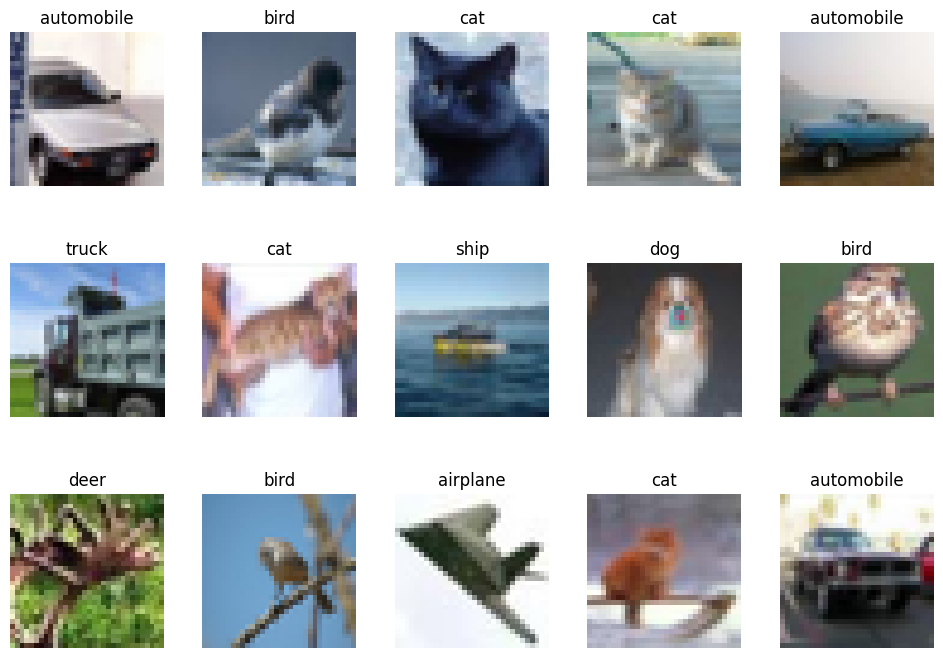

In [3]:
import matplotlib.pyplot as plt

# Assuming x_train, y_train are loaded and contain CIFAR-10 data
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

fig, axes = plt.subplots(3, 5, figsize=(12, 8))
axes = axes.ravel()

for i in range(15):
    index = np.random.randint(0, len(X_train))
    axes[i].imshow(X_train[index])
    axes[i].set_title(class_names[y_train[index][0]])
    axes[i].axis('off')

plt.subplots_adjust(hspace=0.5)


## Class distribution

Next, let's take a look at if the classes are balanced or imbalanced in train and test

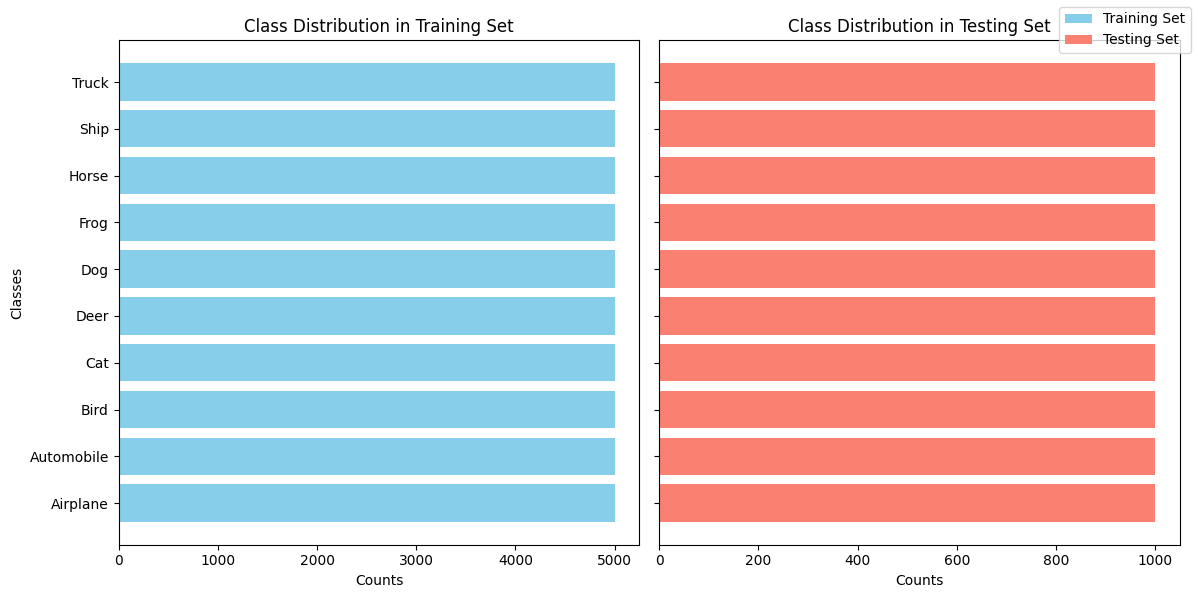

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming y_train and y_test are already defined
classes_name = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer',
                'Dog', 'Frog', 'Horse', 'Ship', 'Truck']

# Calculate class distributions for both training and testing sets
train_classes, train_counts = np.unique(y_train, return_counts=True)
test_classes, test_counts = np.unique(y_test, return_counts=True)

# Create a figure and a set of subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

# Plot training set distribution
axs[0].barh(classes_name, train_counts, color='skyblue')
axs[0].set_title('Class Distribution in Training Set')
axs[0].set_xlabel('Counts')
axs[0].set_ylabel('Classes')

# Plot testing set distribution
axs[1].barh(classes_name, test_counts, color='salmon')
axs[1].set_title('Class Distribution in Testing Set')
axs[1].set_xlabel('Counts')

# Add a legend to clarify the colors represent training and testing sets
fig.legend(['Training Set', 'Testing Set'], loc='upper right')

plt.tight_layout()
plt.show()


As we see the classes are equally distributed amongst in the train and test sets both. Thus, we don't need to perform class balancing.

# Data Preprocessing

Okay, let's begin with data preprocessing.

This preprocessing involves two main steps: normalization and one-hot encoding of the target variable.

## Normalization

So I read about why we do Normalization. It involves scaling the pixel values of images to a range of 0 to 1. This process is essential because it helps in reducing the computational complexity by ensuring that the model trains on a standardized scale, leading to a more stable and faster convergence.



In [5]:
# Normalization
X_train = X_train / 255.0
X_test = X_test / 255.0


## One-Hot Encoding
Since our task is a multi-class classification, we convert the categorical labels into a one-hot encoded format. This encoding transforms the categorical labels into a binary matrix representation, which is more suitable for training neural networks on classification tasks.



In [6]:
from tensorflow.keras.utils import to_categorical

# One-Hot Encoding
y_cat_train = to_categorical(y_train, 10)
y_cat_test = to_categorical(y_test, 10)


Additionally, I read about data augmentation as an optional strategy to further enhance our model's ability to generalize from our training data.

Let's try that out as well.

## Data Augmentation

### Why do data augmentation ?

To improve the model's generalization ability, we implement data augmentation. This technique artificially expands the training dataset by applying random transformations (e.g., rotations, shifts, flips) to the training images. It helps the model learn from a more diversified set of data, reducing the risk of overfitting.

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=0.1
)
train_datagen.fit(X_train)

# Confirming the shape of the preprocessed data
print(f"Training data shape: {X_train.shape}")
print(f"Training target shape: {y_cat_train.shape}")
print(f"Testing data shape: {X_test.shape}")
print(f"Testing target shape: {y_cat_test.shape}")


Training data shape: (50000, 32, 32, 3)
Training target shape: (50000, 10)
Testing data shape: (10000, 32, 32, 3)
Testing target shape: (10000, 10)


# Model Building

## Creating a Baseline Model

Instead of directly writing a final model, let's start by testing a number of different methods.

Let's start with a baseline model.

Here are the key components of this model.

**Convolutional** Layer: Just one convolutional layer with 16 filters, which is the most basic feature extraction layer for a CNN.

**Flatten** **Layer**: Converts the 2D output of the convolutional layer into a 1D array.

**Output** **Layer**: A dense layer with 10 neurons (one for each class) with a softmax activation for classification.


In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense


model = Sequential([
    # Single Convolutional Layer
    Conv2D(16, (3, 3), activation='relu', input_shape=(32, 32, 3)),

    # Flattening the output to feed into a dense layer
    Flatten(),

    # Output Layer with softmax activation for multi-class classification
    Dense(10, activation='softmax')
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 16)        448       
                                                                 
 flatten (Flatten)           (None, 14400)             0         
                                                                 
 dense (Dense)               (None, 10)                144010    
                                                                 
Total params: 144458 (564.29 KB)
Trainable params: 144458 (564.29 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [9]:
!pip install visualkeras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.7/993.7 kB 12.2 MB/s eta 0:00:00


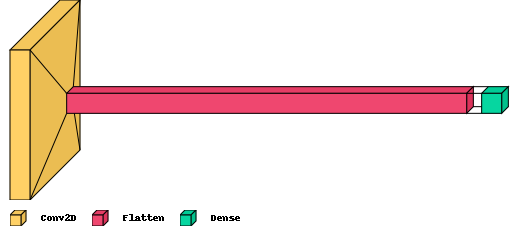

In [10]:
import visualkeras

visualkeras.layered_view(model, spacing=15, legend=True, scale_xy=5, to_file='output.png')

Let's go ahead and train/fit the model

In [11]:
history = model.fit(X_train, y_cat_train, epochs=5, validation_split=0.2)

Epoch 1/5
1250/1250 [==============================] - 34s 27ms/step - loss: 1.5411 - accuracy: 0.4590 - val_loss: 1.3699 - val_accuracy: 0.5276
Epoch 2/5
1250/1250 [==============================] - 22s 17ms/step - loss: 1.2294 - accuracy: 0.5744 - val_loss: 1.2534 - val_accuracy: 0.5641
Epoch 3/5
1250/1250 [==============================] - 19s 15ms/step - loss: 1.1198 - accuracy: 0.6113 - val_loss: 1.2710 - val_accuracy: 0.5588
Epoch 4/5
1250/1250 [==============================] - 19s 15ms/step - loss: 1.0381 - accuracy: 0.6410 - val_loss: 1.2228 - val_accuracy: 0.5856
Epoch 5/5
1250/1250 [==============================] - 18s 14ms/step - loss: 0.9796 - accuracy: 0.6610 - val_loss: 1.2335 - val_accuracy: 0.5803


Next, let's define a function to test the model's accuracy. And other one to see how is accuracy changing and converging over time.


In [12]:
# Function to smooth curves (optional)
def smooth_curve(points, factor=0.8):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

def plot_convergence():

  plt.figure(figsize=(10, 5))
  # Accuracy plot
  plt.subplot(1, 2, 1)
  plt.plot(smooth_curve(history.history['accuracy']), marker='o', label='Train Accuracy')
  plt.plot(smooth_curve(history.history['val_accuracy']), marker='o', label='Validation Accuracy')
  plt.title('Training and Validation Accuracy over Epochs')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.grid(True)
  plt.legend()

  # Loss plot
  plt.subplot(1, 2, 2)
  plt.plot(smooth_curve(history.history['loss']), marker='o', label='Train Loss')
  plt.plot(smooth_curve(history.history['val_loss']), marker='o', label='Validation Loss')
  plt.title('Training and Validation Loss over Epochs')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.grid(True)
  plt.legend()

  plt.tight_layout()
  plt.show()

def test_model_accuracy(model):
  test_loss, test_accuracy = model.evaluate(X_test, y_cat_test)
  print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

  plot_convergence()


313/313 [==============================] - 2s 7ms/step - loss: 1.2436 - accuracy: 0.5763
Test Accuracy: 57.63%


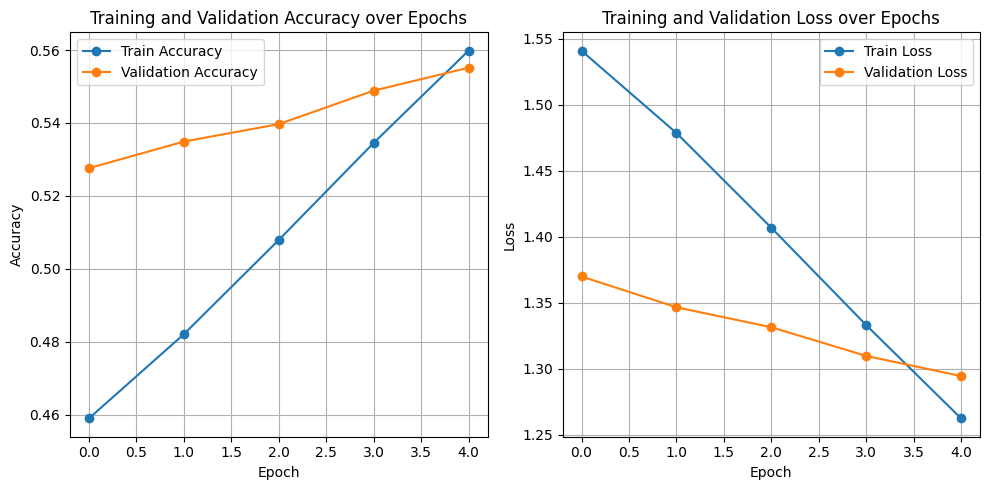

In [13]:
test_model_accuracy(model)

# Current Accuracy - 56% - Baseline Model

## Number of Epochs

Now, An epoch represents one complete pass through the entire training dataset. When we set epochs to a certain number, it means the learning algorithm will work through the entire dataset that many times

Thus, the optimal number of epochs is not a fixed value but is determined empirically. It's based on when we start seeing diminishing returns in reduction of loss on a validation set.

We see that at 5 epochs Accuracy was still increasing, thus now we know to try 15 epochs

In [ ]:
history = model.fit(X_train, y_cat_train, epochs=15, validation_split=0.2)

Epoch 1/15
1250/1250 [==============================] - 18s 14ms/step - loss: 0.6294 - accuracy: 0.7853 - val_loss: 1.4555 - val_accuracy: 0.5659
Epoch 2/15
1250/1250 [==============================] - 18s 14ms/step - loss: 0.6032 - accuracy: 0.7933 - val_loss: 1.4561 - val_accuracy: 0.5666
Epoch 3/15
1250/1250 [==============================] - 17s 14ms/step - loss: 0.5783 - accuracy: 0.8025 - val_loss: 1.4896 - val_accuracy: 0.5695
Epoch 4/15
1250/1250 [==============================] - 17s 14ms/step - loss: 0.5545 - accuracy: 0.8111 - val_loss: 1.5295 - val_accuracy: 0.5679
Epoch 5/15
1250/1250 [==============================] - 18s 15ms/step - loss: 0.5357 - accuracy: 0.8177 - val_loss: 1.5598 - val_accuracy: 0.5638
Epoch 6/15
1250/1250 [==============================] - 18s 14ms/step - loss: 0.5126 - accuracy: 0.8264 - val_loss: 1.6109 - val_accuracy: 0.5559
Epoch 7/15
1250/1250 [==============================] - 19s 15ms/step - loss: 0.4905 - accuracy: 0.8348 - val_loss: 1.6379 -

313/313 [==============================] - 2s 5ms/step - loss: 2.0279 - accuracy: 0.5300
Test Accuracy: 53.00%


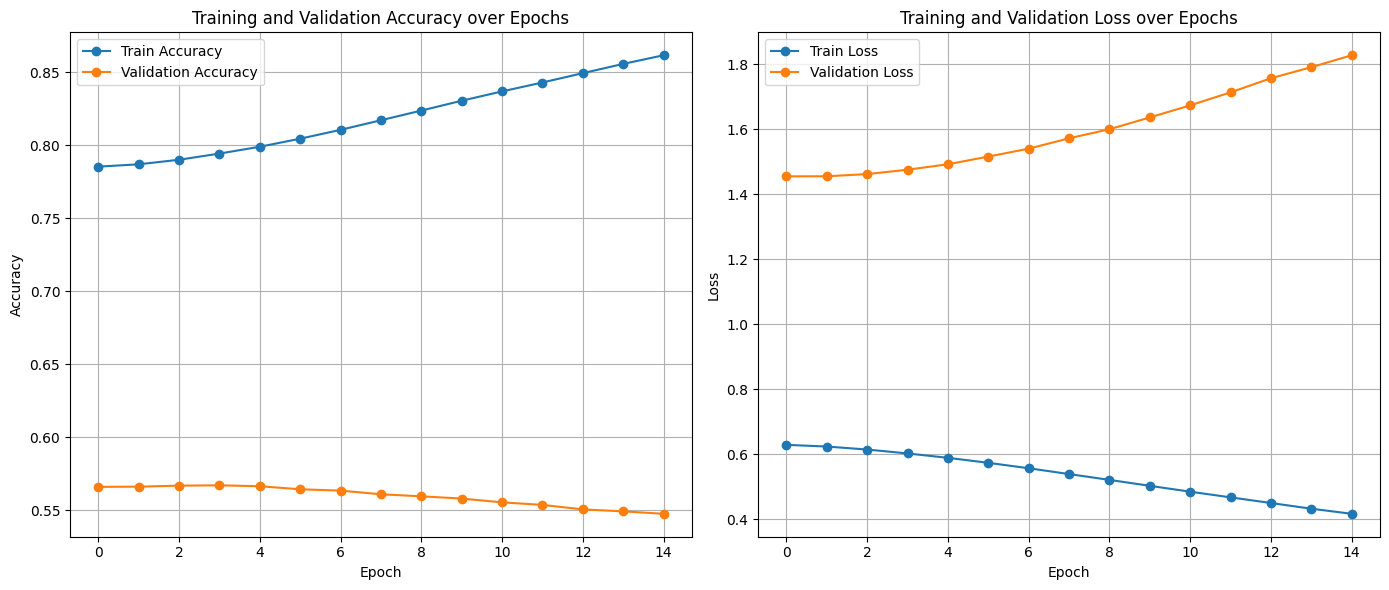

In [ ]:
test_model_accuracy(model)

We see that validation accuracy is no longer exceeding 58% no matter how much we increase the number of epochs

## Batch Size

Next, Understanding Batch Size

Definition: batch_size specifies the number of samples that will be passed through the network at one time. In other words, it's the number of training examples used in one iteration.

In our case, a batch_size of 32 is a common choice for mini-batch gradient descent, providing a balance between computational efficiency and the benefits of stochastic gradient updates.

In [ ]:
history = model.fit(X_train, y_cat_train, epochs=15, validation_split=0.2, batch_size=32)

Epoch 1/15
1250/1250 [==============================] - 22s 17ms/step - loss: 0.3296 - accuracy: 0.8949 - val_loss: 2.1005 - val_accuracy: 0.5293
Epoch 2/15
1250/1250 [==============================] - 17s 13ms/step - loss: 0.3191 - accuracy: 0.8974 - val_loss: 2.0814 - val_accuracy: 0.5448
Epoch 3/15
1250/1250 [==============================] - 18s 15ms/step - loss: 0.3106 - accuracy: 0.8990 - val_loss: 2.1158 - val_accuracy: 0.5432
Epoch 4/15
1250/1250 [==============================] - 17s 14ms/step - loss: 0.2900 - accuracy: 0.9081 - val_loss: 2.1445 - val_accuracy: 0.5406
Epoch 5/15
1250/1250 [==============================] - 17s 13ms/step - loss: 0.2785 - accuracy: 0.9117 - val_loss: 2.1900 - val_accuracy: 0.5360
Epoch 6/15
1250/1250 [==============================] - 18s 14ms/step - loss: 0.2650 - accuracy: 0.9165 - val_loss: 2.2510 - val_accuracy: 0.5345
Epoch 7/15
1250/1250 [==============================] - 17s 13ms/step - loss: 0.2609 - accuracy: 0.9162 - val_loss: 2.3173 -

313/313 [==============================] - 2s 8ms/step - loss: 2.8550 - accuracy: 0.5104
Test Accuracy: 51.04%


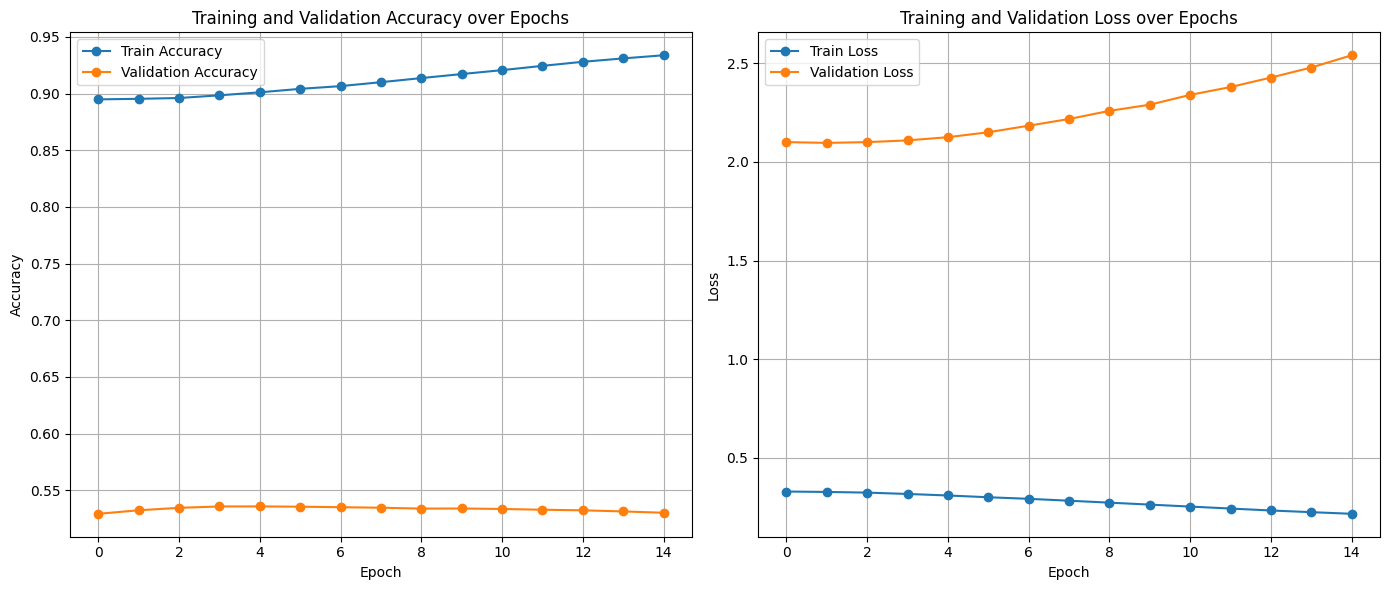

In [ ]:
test_model_accuracy(model)

## Pooling layer.

So A pooling layer is a neural network layer that performs a downsampling operation along the spatial dimensions (width and height) of the input volume.

We studied in class that there are 2 types of Pooling

Max Pooling: This is the most commonly used approach. It partitions the input image into a set of non-overlapping rectangles and, for each such sub-region, outputs the maximum value.

Average Pooling: This method, instead of taking the maximum value, computes the average value of the elements in the sub-region of the input.



In [14]:
model = Sequential([
    # Single Convolutional Layer
    Conv2D(16, (3, 3), activation='relu', input_shape=(32, 32, 3)),
    MaxPooling2D(2, 2),

    # Flattening the output to feed into a dense layer
    Flatten(),

    # Output Layer with softmax activation for multi-class classification
    Dense(10, activation='softmax')
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 30, 30, 16)        448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 15, 15, 16)        0         
 D)                                                              
                                                                 
 flatten_1 (Flatten)         (None, 3600)              0         
                                                                 
 dense_1 (Dense)             (None, 10)                36010     
                                                                 
Total params: 36458 (142.41 KB)
Trainable params: 36458 (142.41 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


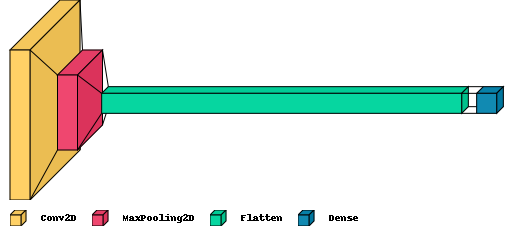

In [15]:
import visualkeras

visualkeras.layered_view(model, spacing=15, legend=True, scale_xy=5, to_file='output.png')

In [ ]:
history = model.fit(X_train, y_cat_train, epochs=8, validation_split=0.2, batch_size=32)

Epoch 1/8
1250/1250 [==============================] - 20s 16ms/step - loss: 1.6443 - accuracy: 0.4254 - val_loss: 1.4280 - val_accuracy: 0.5130
Epoch 2/8
1250/1250 [==============================] - 20s 16ms/step - loss: 1.3405 - accuracy: 0.5309 - val_loss: 1.3499 - val_accuracy: 0.5340
Epoch 3/8
1250/1250 [==============================] - 19s 15ms/step - loss: 1.2428 - accuracy: 0.5667 - val_loss: 1.2693 - val_accuracy: 0.5624
Epoch 4/8
1250/1250 [==============================] - 19s 15ms/step - loss: 1.1800 - accuracy: 0.5874 - val_loss: 1.2491 - val_accuracy: 0.5678
Epoch 5/8
1250/1250 [==============================] - 18s 15ms/step - loss: 1.1333 - accuracy: 0.6073 - val_loss: 1.2662 - val_accuracy: 0.5618
Epoch 6/8
1250/1250 [==============================] - 20s 16ms/step - loss: 1.0994 - accuracy: 0.6181 - val_loss: 1.2018 - val_accuracy: 0.5804
Epoch 7/8
1250/1250 [==============================] - 18s 15ms/step - loss: 1.0682 - accuracy: 0.6288 - val_loss: 1.1929 - val_ac

313/313 [==============================] - 3s 9ms/step - loss: 1.1941 - accuracy: 0.5916
Test Accuracy: 59.16%


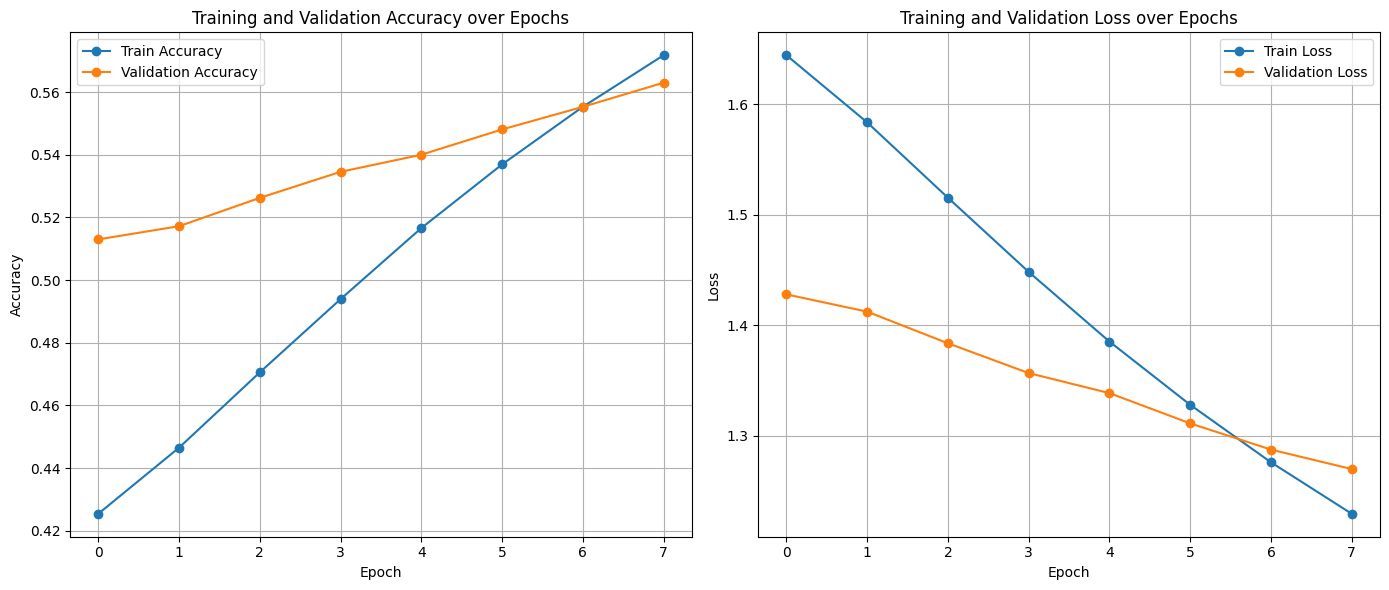

In [ ]:
test_model_accuracy(model)

I think we can increase the number of epochs further as the graphs show an upward trend

In [ ]:
history = model.fit(X_train, y_cat_train, epochs=15, validation_split=0.2, batch_size=32)

Epoch 1/15
1250/1250 [==============================] - 19s 15ms/step - loss: 1.0264 - accuracy: 0.6432 - val_loss: 1.1918 - val_accuracy: 0.5936
Epoch 2/15
1250/1250 [==============================] - 20s 16ms/step - loss: 1.0059 - accuracy: 0.6518 - val_loss: 1.1959 - val_accuracy: 0.5964
Epoch 3/15
1250/1250 [==============================] - 18s 15ms/step - loss: 0.9876 - accuracy: 0.6605 - val_loss: 1.1631 - val_accuracy: 0.6009
Epoch 4/15
1250/1250 [==============================] - 20s 16ms/step - loss: 0.9766 - accuracy: 0.6647 - val_loss: 1.1828 - val_accuracy: 0.5959
Epoch 5/15
1250/1250 [==============================] - 18s 15ms/step - loss: 0.9595 - accuracy: 0.6701 - val_loss: 1.1452 - val_accuracy: 0.6107
Epoch 6/15
1250/1250 [==============================] - 19s 16ms/step - loss: 0.9457 - accuracy: 0.6719 - val_loss: 1.1647 - val_accuracy: 0.6062
Epoch 7/15
1250/1250 [==============================] - 19s 16ms/step - loss: 0.9361 - accuracy: 0.6784 - val_loss: 1.1879 -

313/313 [==============================] - 2s 6ms/step - loss: 1.2112 - accuracy: 0.5977
Test Accuracy: 59.77%


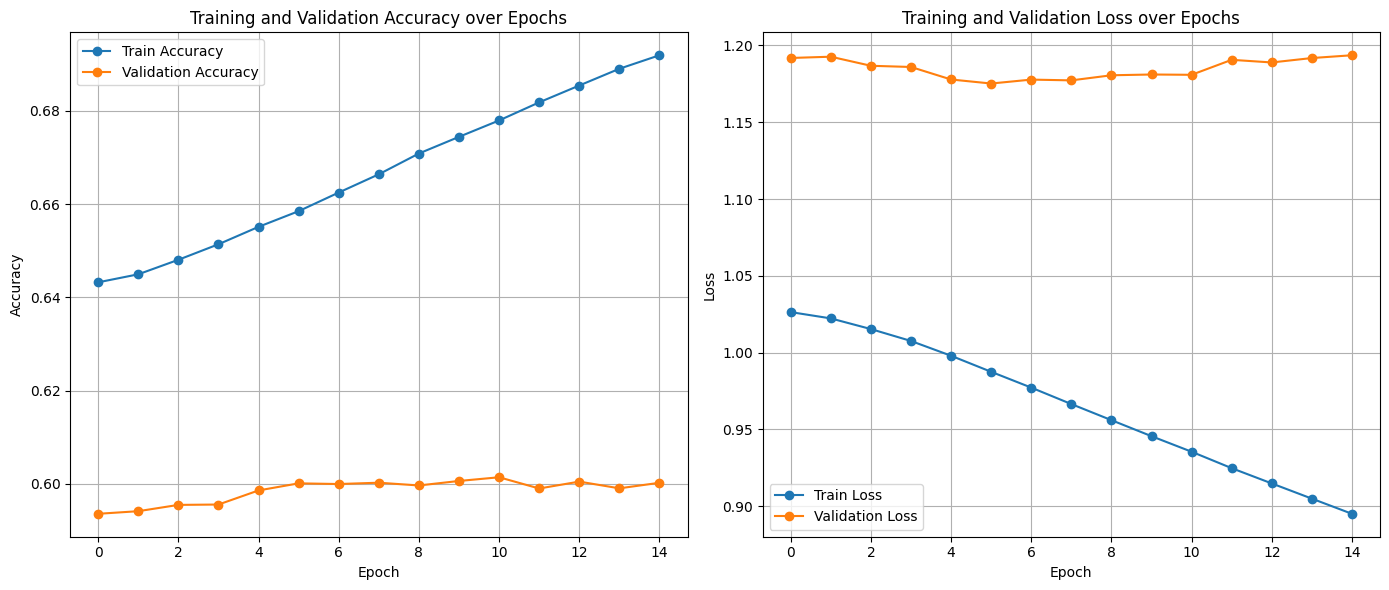

In [ ]:
test_model_accuracy(model)

# Improved Accuracy with Pooling - 59%.

## Batch Normalization

Add Batch Normalization layers, which can help in speeding up training and stabilizing the learning process by normalizing the input layer by re-centering and re-scaling.

Batch Normalization normalizes the output of a previous activation layer by subtracting the batch mean and dividing by the batch standard deviation. In other words, it transforms the outputs of the layer to have a mean of zero and a standard deviation of one (standard normal distribution).

Couple of things to keep in mind :

1. Position in the Network: There's some debate about whether to apply Batch Normalization before or after the activation function. The original paper suggests applying it before the non-linear activation, but some practitioners find benefits in applying it after.
2. Running Mean and Variance: During training, Batch Normalization computes the mean and variance of each feature for each mini-batch. During inference (testing), it uses the running average of these mean and variance values computed during training.
3. Batch Size Dependency: The effectiveness of Batch Normalization can depend on the size of your mini-batches. Very small batch sizes can reduce its effectiveness due to less reliable estimates of the mean and variance.


In [16]:
model = Sequential([
    # Single Convolutional Layer
    Conv2D(16, (3, 3), input_shape=(32, 32, 3)),
    BatchNormalization(),
    Activation('relu'),

    MaxPooling2D(2, 2),

    # Flattening the output to feed into a dense layer
    Flatten(),

    # Output Layer with softmax activation for multi-class classification
    Dense(10, activation='softmax')
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 30, 30, 16)        448       
                                                                 
 batch_normalization (Batch  (None, 30, 30, 16)        64        
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 30, 30, 16)        0         
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 15, 15, 16)        0         
 g2D)                                                            
                                                                 
 flatten_2 (Flatten)         (None, 3600)              0         
                                                                 
 dense_2 (Dense)             (None, 10)               

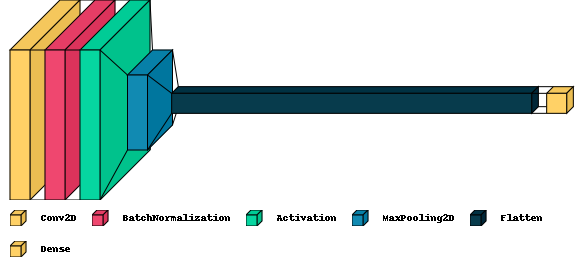

In [17]:
import visualkeras

visualkeras.layered_view(model, spacing=15, legend=True, scale_xy=5, to_file='output.png')

In [ ]:
history = model.fit(X_train, y_cat_train, epochs=15, validation_split=0.2, batch_size=32)

Epoch 1/15
1250/1250 [==============================] - 29s 22ms/step - loss: 1.5618 - accuracy: 0.4642 - val_loss: 1.5328 - val_accuracy: 0.4819
Epoch 2/15
1250/1250 [==============================] - 27s 22ms/step - loss: 1.2423 - accuracy: 0.5686 - val_loss: 1.3725 - val_accuracy: 0.5312
Epoch 3/15
1250/1250 [==============================] - 27s 21ms/step - loss: 1.1379 - accuracy: 0.6079 - val_loss: 1.7203 - val_accuracy: 0.4545
Epoch 4/15
1250/1250 [==============================] - 28s 22ms/step - loss: 1.0631 - accuracy: 0.6340 - val_loss: 1.2187 - val_accuracy: 0.5873
Epoch 5/15
1250/1250 [==============================] - 30s 24ms/step - loss: 1.0047 - accuracy: 0.6533 - val_loss: 1.4607 - val_accuracy: 0.5428
Epoch 6/15
1250/1250 [==============================] - 27s 21ms/step - loss: 0.9639 - accuracy: 0.6690 - val_loss: 1.2586 - val_accuracy: 0.5755
Epoch 7/15
1250/1250 [==============================] - 27s 21ms/step - loss: 0.9331 - accuracy: 0.6788 - val_loss: 1.2404 -

313/313 [==============================] - 3s 9ms/step - loss: 1.3375 - accuracy: 0.5817
Test Accuracy: 58.17%


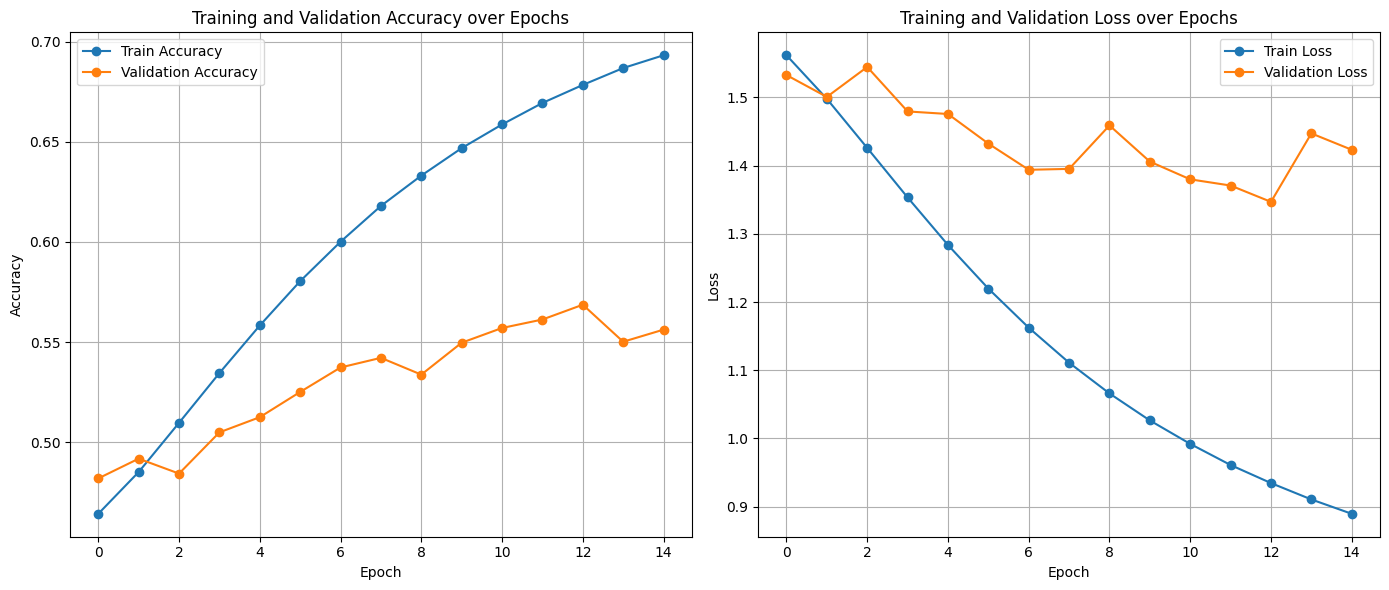

In [ ]:
test_model_accuracy(model)

# No major change in accuracy post Batch Normalization - 58%

## Additional Convolution and Pooling Layers

We know that convolutional layers are the core building blocks of CNNs. They apply a number of filters to the input to create feature maps. These filters help the network in detecting various features such as edges, textures, and more complex patterns in deeper layers.

Let's try adding another set of Convolutional layer. Also let's try switching around the number of parameters for our first convolutional layer and see if this causes the accuracy to increase/decrease


In [18]:
model = Sequential([
    # Single Convolutional Layer
    Conv2D(32, (3, 3), input_shape=(32, 32, 3)),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(2, 2),

    # Second convolutional layer
    Conv2D(64, (3, 3)),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(2, 2),

    # Flattening the output to feed into a dense layer
    Flatten(),

    # Output Layer with softmax activation for multi-class classification
    Dense(10, activation='softmax')
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 30, 30, 32)        896       
                                                                 
 batch_normalization_1 (Bat  (None, 30, 30, 32)        128       
 chNormalization)                                                
                                                                 
 activation_1 (Activation)   (None, 30, 30, 32)        0         
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 15, 15, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 batch_normalization_2 (Bat  (None, 13, 13, 64)       

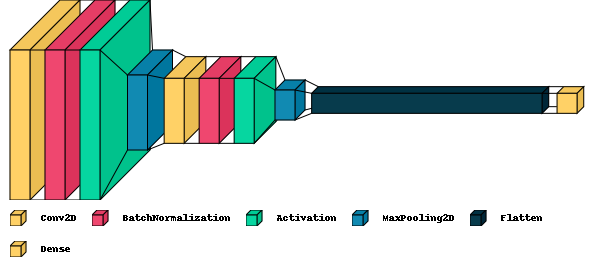

In [19]:
import visualkeras

visualkeras.layered_view(model, spacing=15, legend=True, scale_xy=5, to_file='output.png')

In [ ]:
history = model.fit(X_train, y_cat_train, epochs=10, validation_split=0.2, batch_size=32)

Epoch 1/10
1250/1250 [==============================] - 65s 51ms/step - loss: 1.4184 - accuracy: 0.5055 - val_loss: 1.3898 - val_accuracy: 0.5272
Epoch 2/10
1250/1250 [==============================] - 72s 58ms/step - loss: 1.0638 - accuracy: 0.6278 - val_loss: 1.1239 - val_accuracy: 0.6067
Epoch 3/10
1250/1250 [==============================] - 69s 56ms/step - loss: 0.9431 - accuracy: 0.6753 - val_loss: 1.3119 - val_accuracy: 0.5927
Epoch 4/10
1250/1250 [==============================] - 64s 51ms/step - loss: 0.8631 - accuracy: 0.7031 - val_loss: 1.0474 - val_accuracy: 0.6399
Epoch 5/10
1250/1250 [==============================] - 62s 50ms/step - loss: 0.8008 - accuracy: 0.7246 - val_loss: 1.1128 - val_accuracy: 0.6295
Epoch 6/10
1250/1250 [==============================] - 64s 51ms/step - loss: 0.7526 - accuracy: 0.7421 - val_loss: 1.2606 - val_accuracy: 0.5798
Epoch 7/10
1250/1250 [==============================] - 62s 49ms/step - loss: 0.7009 - accuracy: 0.7617 - val_loss: 1.0700 -

313/313 [==============================] - 5s 16ms/step - loss: 1.4477 - accuracy: 0.5747
Test Accuracy: 57.47%


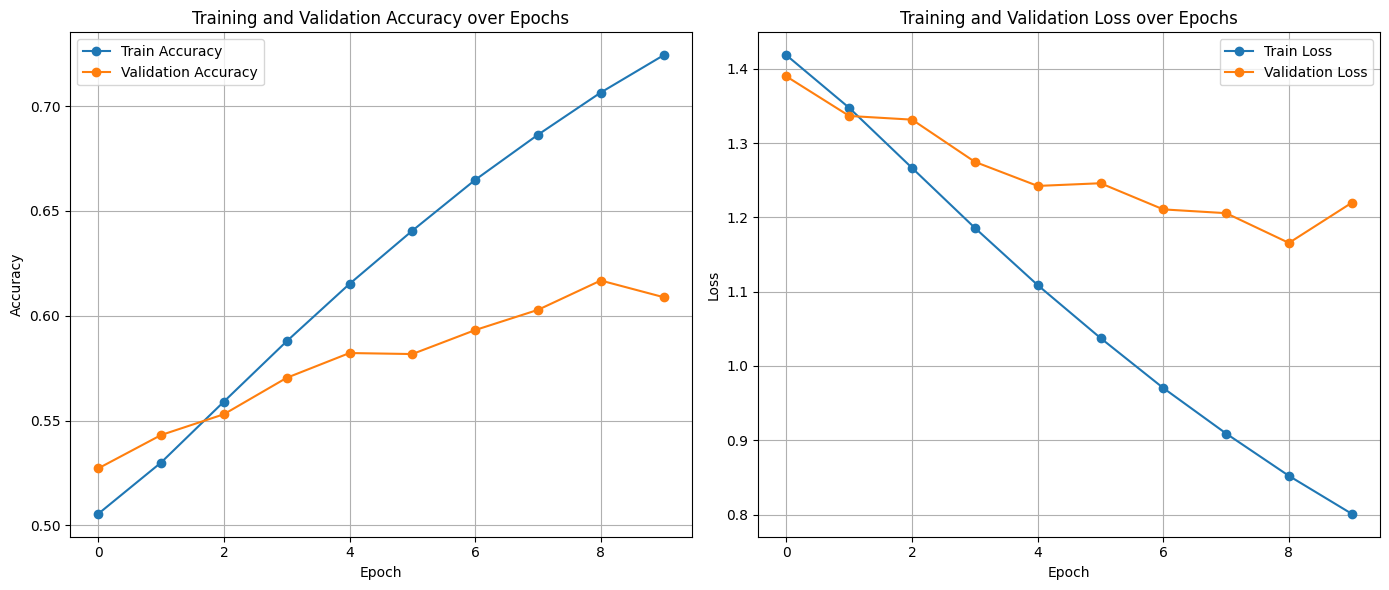

In [ ]:
test_model_accuracy(model)

# No change after adding more conv layers - 57%

## Dropout Layer

While Batch Normalization does offer some regularization, you might consider adding Dropout layers, especially if you encounter overfitting. Dropout layers are typically placed after pooling layers or between dense layers

In [20]:
model = Sequential([
    # Single Convolutional Layer
    Conv2D(32, (3, 3), input_shape=(32, 32, 3)),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(2, 2),
    Dropout(0.25),  # Dropout layer after pooling


    # Second convolutional layer
    Conv2D(64, (3, 3)),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(2, 2),
    Dropout(0.25),  # Dropout layer after pooling

    # Flattening the output to feed into a dense layer
    Flatten(),

    # Output Layer with softmax activation for multi-class classification
    Dense(10, activation='softmax')
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 30, 30, 32)        896       
                                                                 
 batch_normalization_3 (Bat  (None, 30, 30, 32)        128       
 chNormalization)                                                
                                                                 
 activation_3 (Activation)   (None, 30, 30, 32)        0         
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 15, 15, 32)        0         
 g2D)                                                            
                                                                 
 dropout (Dropout)           (None, 15, 15, 32)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 13, 13, 64)       

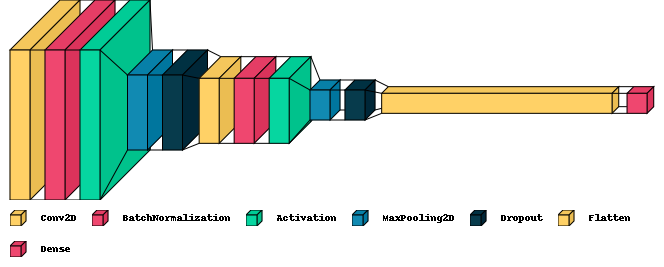

In [21]:
import visualkeras

visualkeras.layered_view(model, spacing=15, legend=True, scale_xy=5, to_file='output.png')

In [ ]:
history = model.fit(X_train, y_cat_train, epochs=10, validation_split=0.2, batch_size=32)

Epoch 1/10
1250/1250 [==============================] - 106s 56ms/step - loss: 1.6259 - accuracy: 0.4388 - val_loss: 1.6260 - val_accuracy: 0.4415
Epoch 2/10
1250/1250 [==============================] - 68s 54ms/step - loss: 1.2008 - accuracy: 0.5771 - val_loss: 1.2225 - val_accuracy: 0.5716
Epoch 3/10
1250/1250 [==============================] - 69s 55ms/step - loss: 1.0827 - accuracy: 0.6244 - val_loss: 1.0803 - val_accuracy: 0.6370
Epoch 4/10
1250/1250 [==============================] - 68s 54ms/step - loss: 1.0136 - accuracy: 0.6471 - val_loss: 0.9484 - val_accuracy: 0.6760
Epoch 5/10
1250/1250 [==============================] - 69s 55ms/step - loss: 0.9645 - accuracy: 0.6655 - val_loss: 1.6675 - val_accuracy: 0.4788
Epoch 6/10
1250/1250 [==============================] - 69s 55ms/step - loss: 0.9288 - accuracy: 0.6777 - val_loss: 0.9917 - val_accuracy: 0.6680
Epoch 7/10
1250/1250 [==============================] - 68s 55ms/step - loss: 0.8978 - accuracy: 0.6911 - val_loss: 1.0208 

313/313 [==============================] - 5s 17ms/step - loss: 0.9029 - accuracy: 0.6941
Test Accuracy: 69.41%


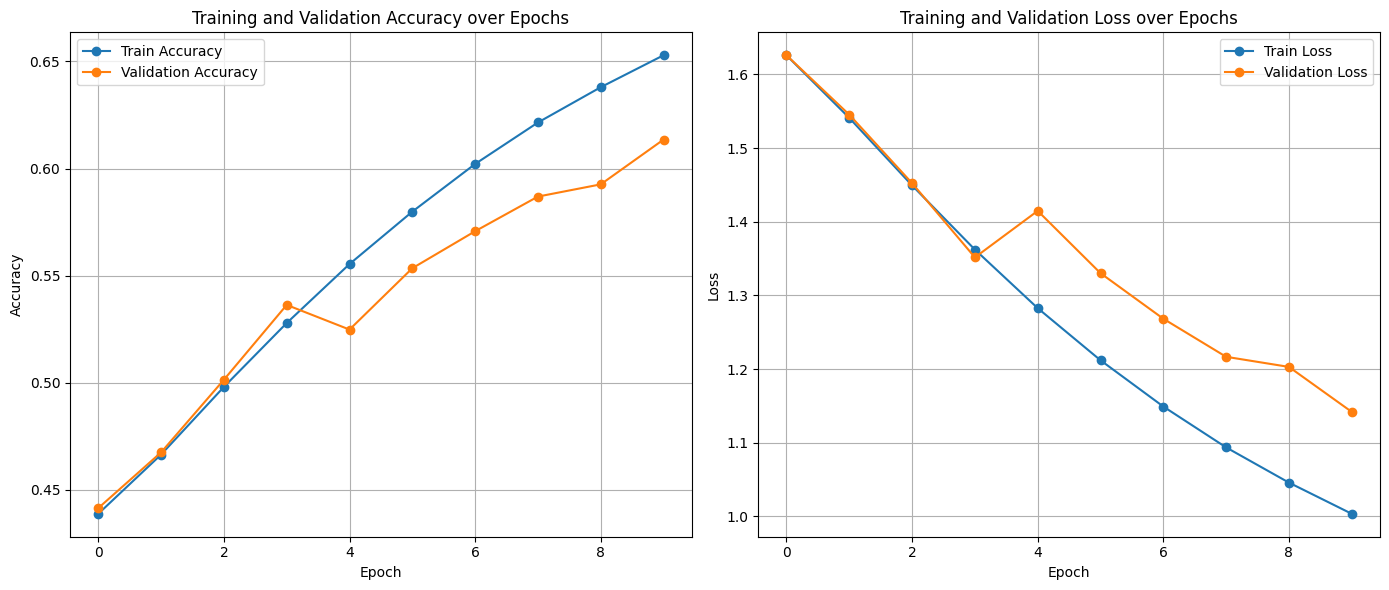

In [ ]:
test_model_accuracy(model)

# Major Improvement after adding drop out layer - 69%

Since the graphs showed improvement, let's try increasing the number of epochs

In [ ]:
history = model.fit(X_train, y_cat_train, epochs=20, validation_split=0.2, batch_size=32)

Epoch 1/20
1250/1250 [==============================] - 68s 55ms/step - loss: 0.8161 - accuracy: 0.7177 - val_loss: 0.9791 - val_accuracy: 0.6580
Epoch 2/20
1250/1250 [==============================] - 67s 54ms/step - loss: 0.8025 - accuracy: 0.7210 - val_loss: 0.9372 - val_accuracy: 0.6765
Epoch 3/20
1250/1250 [==============================] - 67s 54ms/step - loss: 0.7912 - accuracy: 0.7255 - val_loss: 1.0461 - val_accuracy: 0.6481
Epoch 4/20
1250/1250 [==============================] - 68s 54ms/step - loss: 0.7842 - accuracy: 0.7272 - val_loss: 0.9313 - val_accuracy: 0.6821
Epoch 5/20
1250/1250 [==============================] - 72s 58ms/step - loss: 0.7768 - accuracy: 0.7306 - val_loss: 0.8806 - val_accuracy: 0.6975
Epoch 6/20
1250/1250 [==============================] - 67s 54ms/step - loss: 0.7649 - accuracy: 0.7345 - val_loss: 0.8631 - val_accuracy: 0.7087
Epoch 7/20
1250/1250 [==============================] - 67s 54ms/step - loss: 0.7611 - accuracy: 0.7379 - val_loss: 0.8275 -

313/313 [==============================] - 5s 17ms/step - loss: 0.9409 - accuracy: 0.6773
Test Accuracy: 67.73%


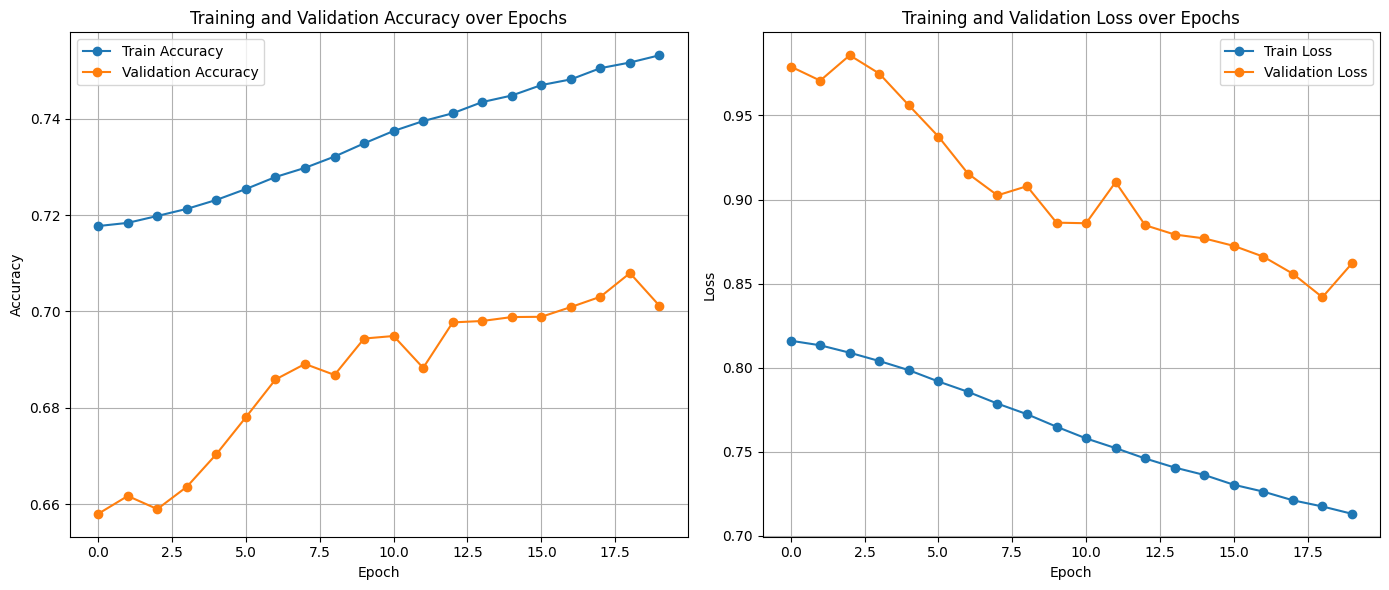

In [ ]:
test_model_accuracy(model)

## Early Stopping

So early stopping callback is an effective way to reduce training time, especially when you've reached a point where further training does not meaningfully improve model performance. Early stopping monitors a specified metric (such as validation loss) and stops the training process once this metric stops improving for a specified number of epochs. This not only saves time but also helps prevent overfitting

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=3,         # Number of epochs with no improvement after which training will be stopped
    min_delta=0.01,    # Minimum change to qualify as an improvement
    mode='min',         # The training will stop when the quantity monitored stops decreasing
    verbose=1           # Print messages when early stopping is triggered
)

history = model.fit(
    X_train, y_cat_train,
    epochs=15,  # Set a high number of epochs
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping]  # Include the early stopping callback
)


Epoch 1/15
1250/1250 [==============================] - 71s 57ms/step - loss: 0.6968 - accuracy: 0.7585 - val_loss: 0.7777 - val_accuracy: 0.7329
Epoch 2/15
1250/1250 [==============================] - 69s 55ms/step - loss: 0.6878 - accuracy: 0.7626 - val_loss: 0.8654 - val_accuracy: 0.7008
Epoch 3/15
1250/1250 [==============================] - 69s 55ms/step - loss: 0.6861 - accuracy: 0.7624 - val_loss: 0.8113 - val_accuracy: 0.7255
Epoch 4/15
1250/1250 [==============================] - 69s 55ms/step - loss: 0.6848 - accuracy: 0.7616 - val_loss: 0.8469 - val_accuracy: 0.7054
Epoch 4: early stopping


313/313 [==============================] - 4s 14ms/step - loss: 0.8535 - accuracy: 0.7077
Test Accuracy: 70.77%


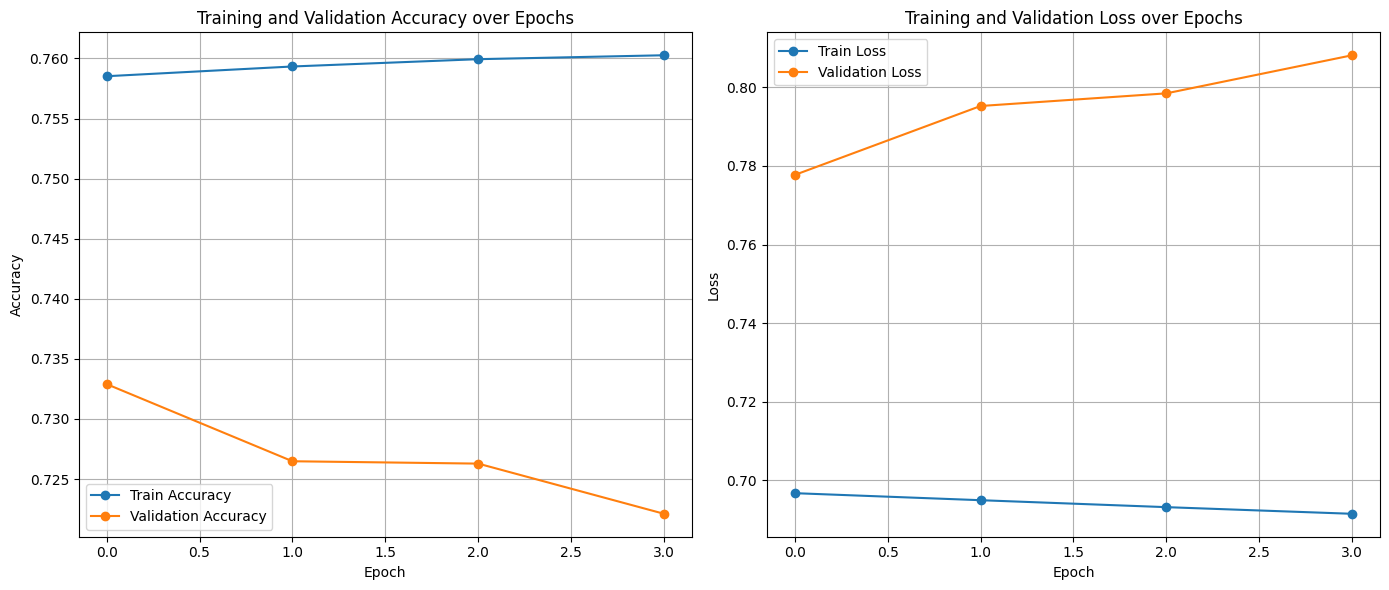

In [ ]:
test_model_accuracy(model)

# Improved after Early stopping - 70% accuracy on the 4th Epoch

## Addition of more dense layers

Now dense layers, which is the same as fully connected layers, are a standard component in neural networks where all the neurons from the previous layer are connected to each neuron in the dense layer.

Let's try adding a couple more dense layers. And dropout layers along side them to avoid overfitting.

In [22]:
model = Sequential([
    # Single Convolutional Layer
    Conv2D(32, (3, 3), input_shape=(32, 32, 3)),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(2, 2),
    Dropout(0.25),  # Dropout layer after pooling


    # Second convolutional layer
    Conv2D(64, (3, 3)),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(2, 2),
    Dropout(0.25),  # Dropout layer after pooling

    # Flattening the output to feed into a dense layer
    Flatten(),

    # First Dense Layer
    Dense(128, activation='relu'),
    Dropout(0.5),

    # Additional Dense Layer
    Dense(64, activation='relu'),
    Dropout(0.5),

    # Output Layer with softmax activation for multi-class classification
    Dense(10, activation='softmax')
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 30, 30, 32)        896       
                                                                 
 batch_normalization_5 (Bat  (None, 30, 30, 32)        128       
 chNormalization)                                                
                                                                 
 activation_5 (Activation)   (None, 30, 30, 32)        0         
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 15, 15, 32)        0         
 g2D)                                                            
                                                                 
 dropout_2 (Dropout)         (None, 15, 15, 32)        0         
                                                                 
 conv2d_8 (Conv2D)           (None, 13, 13, 64)       

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=3,         # Number of epochs with no improvement after which training will be stopped
    min_delta=0.01,    # Minimum change to qualify as an improvement
    mode='min',         # The training will stop when the quantity monitored stops decreasing
    verbose=1           # Print messages when early stopping is triggered
)

history = model.fit(
    X_train, y_cat_train,
    epochs=15,  # Set a high number of epochs
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping]  # Include the early stopping callback
)


Epoch 1/15
1250/1250 [==============================] - 76s 60ms/step - loss: 2.1778 - accuracy: 0.1597 - val_loss: 2.1159 - val_accuracy: 0.1853
Epoch 2/15
1250/1250 [==============================] - 76s 61ms/step - loss: 1.9347 - accuracy: 0.2371 - val_loss: 1.9468 - val_accuracy: 0.2311
Epoch 3/15
1250/1250 [==============================] - 76s 61ms/step - loss: 1.8180 - accuracy: 0.2790 - val_loss: 1.7708 - val_accuracy: 0.3144
Epoch 4/15
1250/1250 [==============================] - 75s 60ms/step - loss: 1.7507 - accuracy: 0.3042 - val_loss: 1.7390 - val_accuracy: 0.3176
Epoch 5/15
1250/1250 [==============================] - 74s 59ms/step - loss: 1.7066 - accuracy: 0.3280 - val_loss: 1.6355 - val_accuracy: 0.3556
Epoch 6/15
1250/1250 [==============================] - 74s 59ms/step - loss: 1.6565 - accuracy: 0.3555 - val_loss: 1.7000 - val_accuracy: 0.3692
Epoch 7/15
1250/1250 [==============================] - 74s 59ms/step - loss: 1.6118 - accuracy: 0.3781 - val_loss: 1.4859 -

313/313 [==============================] - 4s 14ms/step - loss: 1.4052 - accuracy: 0.4878
Test Accuracy: 48.78%


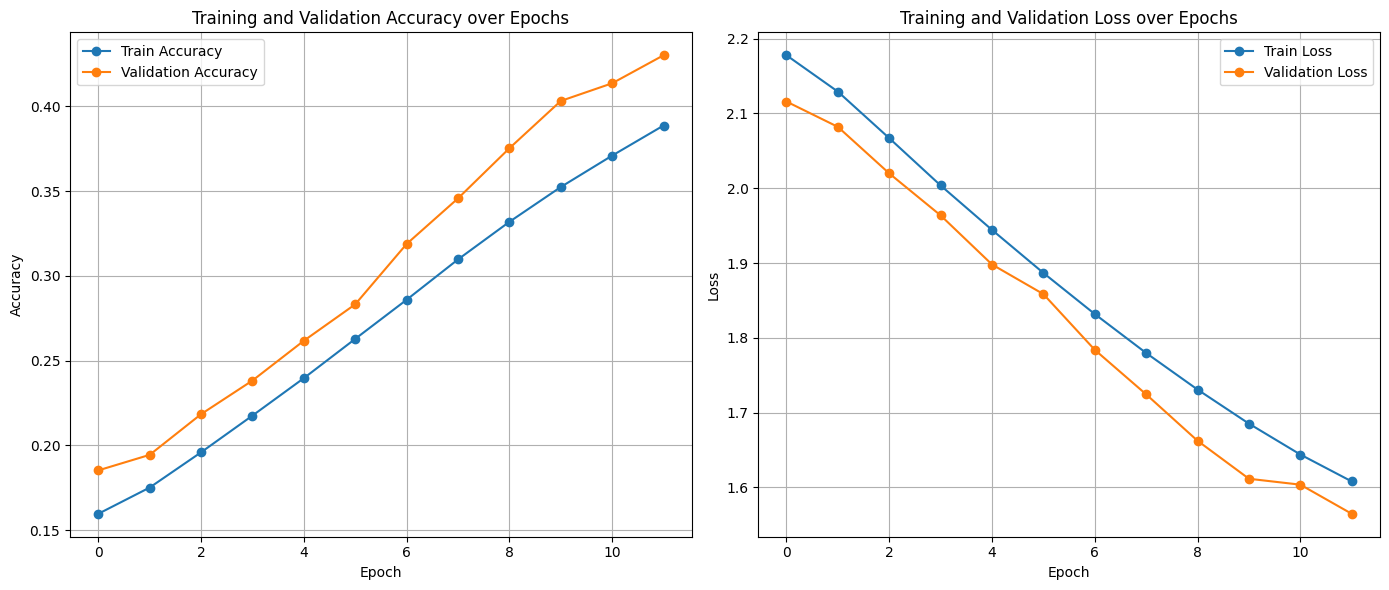

In [ ]:
test_model_accuracy(model)

### Pontential Underfitting

Okay, so what do these graphs suggest ?

That our model is still underfitting. So, we need more epochs. Let's try 50 instead of 10.

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=3,         # Number of epochs with no improvement after which training will be stopped
    min_delta=0.001,    # Minimum change to qualify as an improvement
    mode='min',         # The training will stop when the quantity monitored stops decreasing
    verbose=1           # Print messages when early stopping is triggered
)

history = model.fit(
    X_train, y_cat_train,
    epochs=50,  # Set a high number of epochs
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping]  # Include the early stopping callback
)


Epoch 1/50
1250/1250 [==============================] - 77s 62ms/step - loss: 1.4344 - accuracy: 0.4674 - val_loss: 1.2625 - val_accuracy: 0.5575
Epoch 2/50
1250/1250 [==============================] - 76s 61ms/step - loss: 1.4162 - accuracy: 0.4787 - val_loss: 1.4009 - val_accuracy: 0.5045
Epoch 3/50
1250/1250 [==============================] - 75s 60ms/step - loss: 1.3915 - accuracy: 0.4866 - val_loss: 1.3246 - val_accuracy: 0.5209
Epoch 4/50
1250/1250 [==============================] - 78s 62ms/step - loss: 1.3759 - accuracy: 0.4974 - val_loss: 1.4461 - val_accuracy: 0.4557
Epoch 4: early stopping


313/313 [==============================] - 5s 17ms/step - loss: 1.4563 - accuracy: 0.4497
Test Accuracy: 44.97%


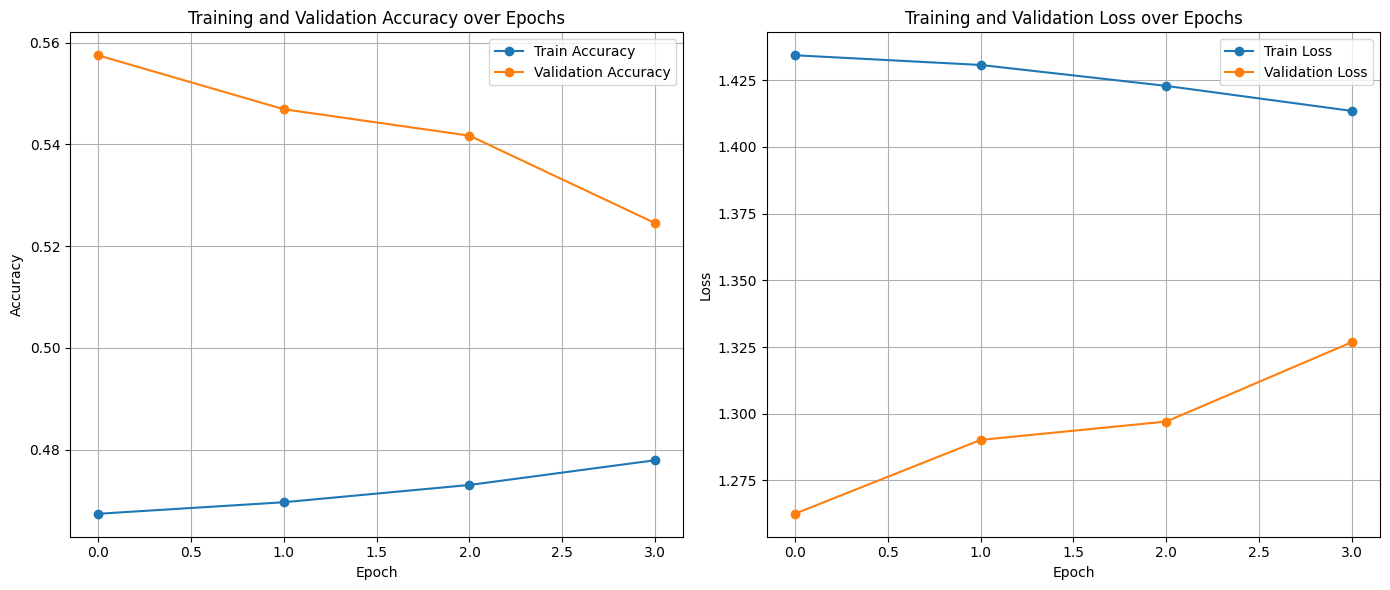

In [ ]:
test_model_accuracy(model)

Still no improvement, well let's try reducing one of the dense and reducing the dropout values as well to see if that does something.

In [23]:
from tensorflow.keras.layers import LeakyReLU

model = Sequential([
    # Single Convolutional Layer
    Conv2D(32, (3, 3), input_shape=(32, 32, 3)),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(2, 2),
    Dropout(0.25),  # Dropout layer after pooling


    # Second convolutional layer
    Conv2D(64, (3, 3)),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(2, 2),
    Dropout(0.25),  # Dropout layer after pooling

    # Flattening the output to feed into a dense layer
    Flatten(),

    # First Dense Layer
    Dense(128, activation='relu'),
    Dropout(0.15),

    # Output Layer with softmax activation for multi-class classification
    Dense(10, activation='softmax')
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 30, 30, 32)        896       
                                                                 
 batch_normalization_7 (Bat  (None, 30, 30, 32)        128       
 chNormalization)                                                
                                                                 
 activation_7 (Activation)   (None, 30, 30, 32)        0         
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 15, 15, 32)        0         
 g2D)                                                            
                                                                 
 dropout_6 (Dropout)         (None, 15, 15, 32)        0         
                                                                 
 conv2d_10 (Conv2D)          (None, 13, 13, 64)       

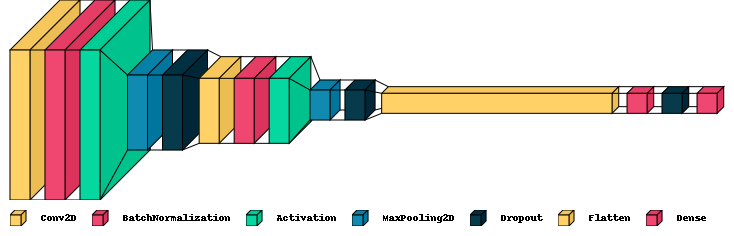

In [24]:
import visualkeras

visualkeras.layered_view(model, spacing=15, legend=True, scale_xy=5, to_file='output.png')

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=3,         # Number of epochs with no improvement after which training will be stopped
    min_delta=0.001,    # Minimum change to qualify as an improvement
    mode='min',         # The training will stop when the quantity monitored stops decreasing
    verbose=1           # Print messages when early stopping is triggered
)

history = model.fit(
    X_train, y_cat_train,
    epochs=50,  # Set a high number of epochs
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping]  # Include the early stopping callback
)


Epoch 1/50
1250/1250 [==============================] - 91s 71ms/step - loss: 1.6683 - accuracy: 0.3882 - val_loss: 1.3519 - val_accuracy: 0.5113
Epoch 2/50
1250/1250 [==============================] - 71s 57ms/step - loss: 1.3691 - accuracy: 0.5061 - val_loss: 1.2468 - val_accuracy: 0.5738
Epoch 3/50
1250/1250 [==============================] - 67s 54ms/step - loss: 1.2509 - accuracy: 0.5507 - val_loss: 1.2291 - val_accuracy: 0.5740
Epoch 4/50
1250/1250 [==============================] - 67s 54ms/step - loss: 1.1756 - accuracy: 0.5820 - val_loss: 1.1321 - val_accuracy: 0.5888
Epoch 5/50
1250/1250 [==============================] - 68s 54ms/step - loss: 1.1269 - accuracy: 0.6024 - val_loss: 1.0163 - val_accuracy: 0.6503
Epoch 6/50
1250/1250 [==============================] - 69s 55ms/step - loss: 1.0914 - accuracy: 0.6154 - val_loss: 0.9964 - val_accuracy: 0.6560
Epoch 7/50
1250/1250 [==============================] - 68s 54ms/step - loss: 1.0571 - accuracy: 0.6266 - val_loss: 1.1864 -

313/313 [==============================] - 5s 14ms/step - loss: 0.9735 - accuracy: 0.6744
Test Accuracy: 67.44%


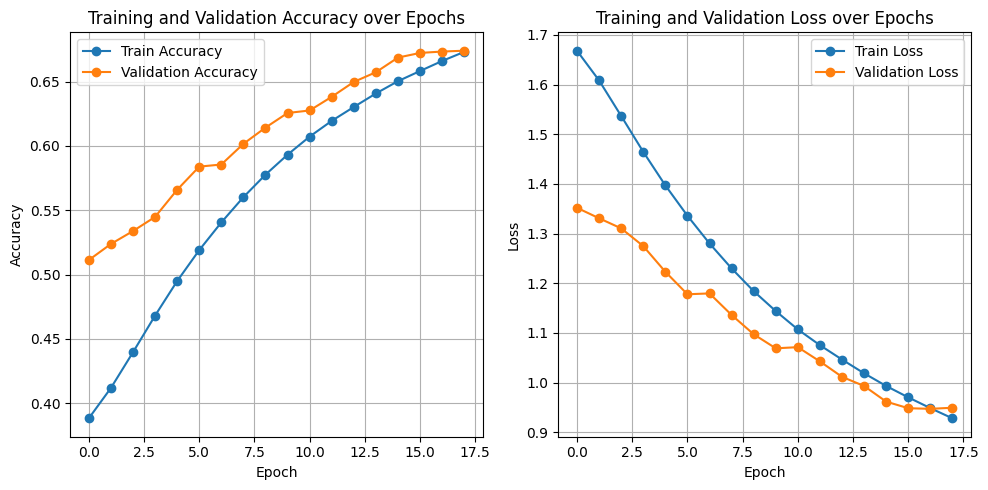

In [ ]:
test_model_accuracy(model)

## Activation Functions

So, the primary role of activation functions is to introduce non-linear properties to the network, enabling it to learn more complex functions.

There are a number of these activation functions.

1. Sigmoid or Logistic Function:

- Formula: σ(x) = 1 / (1 + exp(-x))
- Output Range: (0, 1)
- Use Case: Often used in the output layer of a binary classification model.
- Pros: Smooth gradient, output values bound between 0 and - Cons: Prone to vanishing gradient problem, not zero-centered.

2. Hyperbolic Tangent (tanh):

- Formula: tanh(x) = 2σ(2x) - 1
- Output Range: (-1, 1)
- Use Case: Hidden layers of a neural network since data is centered around zero.
- Pros: Zero-centered, making optimization easier in some cases.
- Cons: Also prone to the vanishing gradient problem.

3. Rectified Linear Unit (ReLU):

- Formula: f(x) = max(0, x)
- Output Range: [0, ∞)
- Use Case: Most widely used in hidden layers of neural networks.
- Pros: Solves vanishing gradient problem, computationally efficient.
- Cons: Neurons can "die" during training (dead ReLU problem).

4. Leaky ReLU:

- Formula: f(x) = x if x > 0, else αx (α is a small constant)
- Use Case: To address the dying neuron problem in ReLU.
- Pros: Prevents neurons from dying.

5. Softmax:

- Formula: Converts a vector of values to a probability distribution.
- Use Case: Output layer for multi-class classification problems.
- Pros: Outputs sum to 1, providing a probabilistic interpretation.



**Now, I tried a number of these functions but I couldn't get any better results. So I've included their names and properties here alongside an example.**

In [25]:
from tensorflow.keras.layers import LeakyReLU

model = Sequential([
    # Single Convolutional Layer
    Conv2D(32, (3, 3), input_shape=(32, 32, 3)),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(2, 2),
    Dropout(0.25),  # Dropout layer after pooling


    # Second convolutional layer
    Conv2D(64, (3, 3)),
    BatchNormalization(),
    LeakyReLU(alpha=0.01),
    MaxPooling2D(2, 2),
    Dropout(0.25),  # Dropout layer after pooling

    # Flattening the output to feed into a dense layer
    Flatten(),

    # First Dense Layer
    Dense(128, activation='relu'),
    Dropout(0.15),

    # Output Layer with softmax activation for multi-class classification
    Dense(10, activation='softmax')
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_11 (Conv2D)          (None, 30, 30, 32)        896       
                                                                 
 batch_normalization_9 (Bat  (None, 30, 30, 32)        128       
 chNormalization)                                                
                                                                 
 activation_9 (Activation)   (None, 30, 30, 32)        0         
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 15, 15, 32)        0         
 ng2D)                                                           
                                                                 
 dropout_9 (Dropout)         (None, 15, 15, 32)        0         
                                                                 
 conv2d_12 (Conv2D)          (None, 13, 13, 64)       

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=3,         # Number of epochs with no improvement after which training will be stopped
    min_delta=0.001,    # Minimum change to qualify as an improvement
    mode='min',         # The training will stop when the quantity monitored stops decreasing
    verbose=1           # Print messages when early stopping is triggered
)

history = model.fit(
    X_train, y_cat_train,
    epochs=50,  # Set a high number of epochs
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping]  # Include the early stopping callback
)


Epoch 1/50
1250/1250 [==============================] - 74s 57ms/step - loss: 1.6285 - accuracy: 0.4099 - val_loss: 1.4479 - val_accuracy: 0.4620
Epoch 2/50
1250/1250 [==============================] - 72s 58ms/step - loss: 1.3220 - accuracy: 0.5273 - val_loss: 1.1512 - val_accuracy: 0.5880
Epoch 3/50
1250/1250 [==============================] - 80s 64ms/step - loss: 1.2019 - accuracy: 0.5722 - val_loss: 1.1042 - val_accuracy: 0.6051
Epoch 4/50
1250/1250 [==============================] - 79s 63ms/step - loss: 1.1248 - accuracy: 0.6008 - val_loss: 1.1700 - val_accuracy: 0.5876
Epoch 5/50
1250/1250 [==============================] - 71s 57ms/step - loss: 1.0739 - accuracy: 0.6209 - val_loss: 1.0307 - val_accuracy: 0.6452
Epoch 6/50
1250/1250 [==============================] - 69s 55ms/step - loss: 1.0436 - accuracy: 0.6335 - val_loss: 1.0368 - val_accuracy: 0.6369
Epoch 7/50
1250/1250 [==============================] - 70s 56ms/step - loss: 1.0068 - accuracy: 0.6448 - val_loss: 0.9860 -

313/313 [==============================] - 5s 15ms/step - loss: 1.3104 - accuracy: 0.5928
Test Accuracy: 59.28%


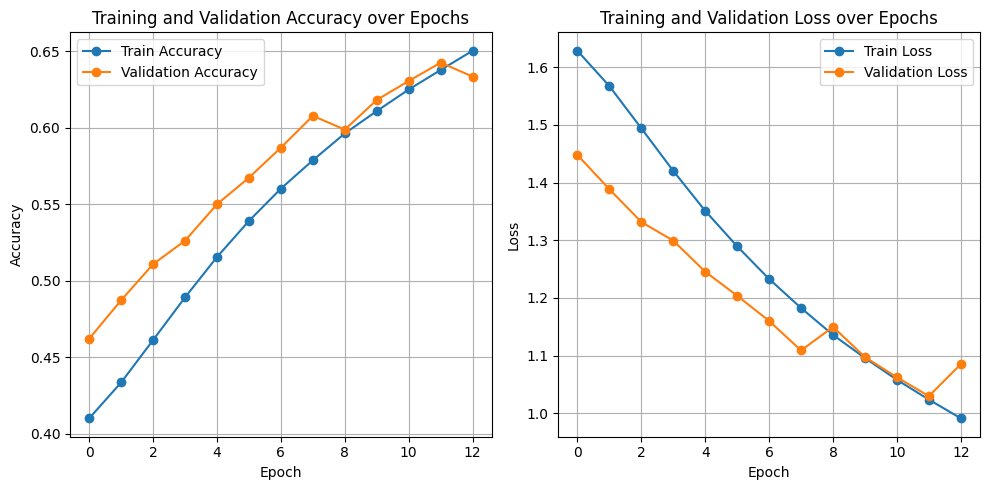

In [ ]:
test_model_accuracy(model)

### As we see here, LeakyRelu performs worse compared to relu.

## Learning Rate and Optimizer

Okay, I tried modifying and adding layers of all sorts. Next, I moved to the compile code, specifically I learnt about :
1. Optimizers are algorithms or methods used to change the attributes of the neural network, such as weights and learning rate, to reduce the losses.

2. Learning Rate : it determines the size of the steps the model takes during training with the aim of reaching a minimum loss.

Let's try and SGD Optimizer and different learning rates

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import SGD


model = Sequential([
    # Single Convolutional Layer
    Conv2D(32, (3, 3), input_shape=(32, 32, 3)),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(2, 2),
    Dropout(0.25),  # Dropout layer after pooling


    # Second convolutional layer
    Conv2D(64, (3, 3)),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(2, 2),
    Dropout(0.25),  # Dropout layer after pooling

    # Flattening the output to feed into a dense layer
    Flatten(),

    # First Dense Layer
    Dense(128, activation='relu'),
    Dropout(0.15),

    # Output Layer with softmax activation for multi-class classification
    Dense(10, activation='softmax')
])


optimizer = SGD(learning_rate=0.01, momentum=0.9)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])


early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=3,         # Number of epochs with no improvement after which training will be stopped
    min_delta=0.001,    # Minimum change to qualify as an improvement
    mode='min',         # The training will stop when the quantity monitored stops decreasing
    verbose=1           # Print messages when early stopping is triggered
)

history = model.fit(
    X_train, y_cat_train,
    epochs=50,  # Set a high number of epochs
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping]  # Include the early stopping callback
)


Epoch 1/50
1250/1250 [==============================] - 70s 55ms/step - loss: 1.7218 - accuracy: 0.3768 - val_loss: 1.4776 - val_accuracy: 0.4728
Epoch 2/50
1250/1250 [==============================] - 66s 53ms/step - loss: 1.3985 - accuracy: 0.4970 - val_loss: 1.2692 - val_accuracy: 0.5591
Epoch 3/50
1250/1250 [==============================] - 68s 54ms/step - loss: 1.2507 - accuracy: 0.5587 - val_loss: 1.1192 - val_accuracy: 0.6012
Epoch 4/50
1250/1250 [==============================] - 66s 53ms/step - loss: 1.1551 - accuracy: 0.5941 - val_loss: 1.1859 - val_accuracy: 0.5830
Epoch 5/50
1250/1250 [==============================] - 67s 53ms/step - loss: 1.0881 - accuracy: 0.6197 - val_loss: 1.7092 - val_accuracy: 0.4779
Epoch 6/50
1250/1250 [==============================] - 64s 51ms/step - loss: 1.0349 - accuracy: 0.6389 - val_loss: 1.0295 - val_accuracy: 0.6415
Epoch 7/50
1250/1250 [==============================] - 69s 55ms/step - loss: 0.9902 - accuracy: 0.6527 - val_loss: 0.9404 -

313/313 [==============================] - 4s 13ms/step - loss: 0.8063 - accuracy: 0.7178
Test Accuracy: 71.78%


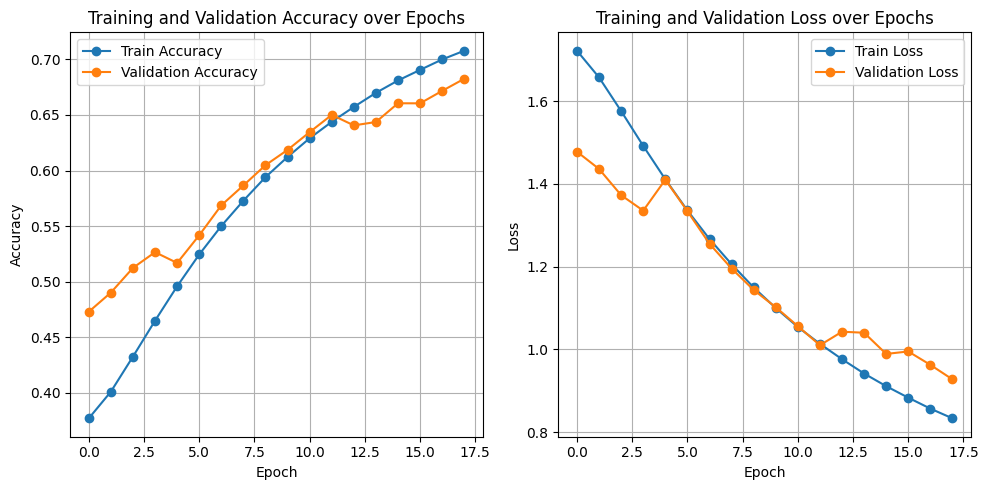

In [ ]:
test_model_accuracy(model)

## Increasing Complexity of the model.

Now, that we have tried out most of the things possible. Let's try a little bit more to get the accuracy to reach above 80%

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import SGD


model = Sequential([
    # Single Convolutional Layer
    Conv2D(64, (3, 3), input_shape=(32, 32, 3)),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(64, (3, 3), input_shape=(32, 32, 3)),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(2, 2),
    Dropout(0.25),  # Dropout layer after pooling


    # Second convolutional layer
    Conv2D(128, (3, 3)),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(128, (3, 3)),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(2, 2),
    Dropout(0.25),  # Dropout layer after pooling

    # Flattening the output to feed into a dense layer
    Flatten(),

    # First Dense Layer
    Dense(128, activation='relu'),
    Dropout(0.25),

    # Output Layer with softmax activation for multi-class classification
    Dense(10, activation='softmax')
])


optimizer = SGD(learning_rate=0.01, momentum=0.9)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])


early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=3,         # Number of epochs with no improvement after which training will be stopped
    min_delta=0.0005,    # Minimum change to qualify as an improvement
    mode='min',         # The training will stop when the quantity monitored stops decreasing
    verbose=1           # Print messages when early stopping is triggered
)

history = model.fit(
    X_train, y_cat_train,
    epochs=32,  # Set a high number of epochs
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping]  # Include the early stopping callback
)


Epoch 1/32
1250/1250 [==============================] - 428s 342ms/step - loss: 1.7977 - accuracy: 0.3361 - val_loss: 1.6471 - val_accuracy: 0.3994
Epoch 2/32
1250/1250 [==============================] - 423s 339ms/step - loss: 1.5079 - accuracy: 0.4527 - val_loss: 1.2847 - val_accuracy: 0.5473
Epoch 3/32
1250/1250 [==============================] - 419s 335ms/step - loss: 1.2856 - accuracy: 0.5419 - val_loss: 1.0693 - val_accuracy: 0.6252
Epoch 4/32
1250/1250 [==============================] - 418s 335ms/step - loss: 1.1300 - accuracy: 0.6012 - val_loss: 1.0320 - val_accuracy: 0.6346
Epoch 5/32
1250/1250 [==============================] - 421s 336ms/step - loss: 1.0149 - accuracy: 0.6456 - val_loss: 0.9240 - val_accuracy: 0.6862
Epoch 6/32
1250/1250 [==============================] - 418s 334ms/step - loss: 0.9161 - accuracy: 0.6826 - val_loss: 0.8412 - val_accuracy: 0.7095
Epoch 7/32
1250/1250 [==============================] - 413s 330ms/step - loss: 0.8338 - accuracy: 0.7099 - val_

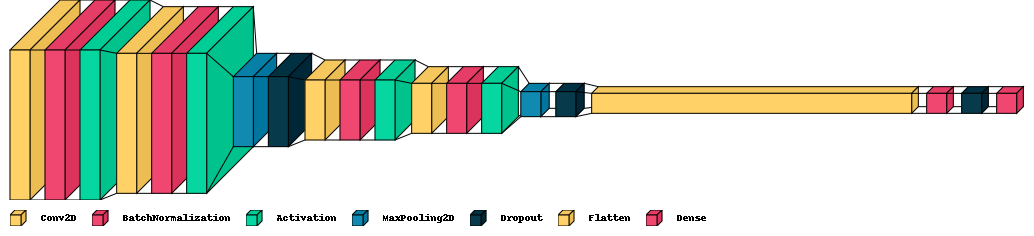

In [30]:
import visualkeras

visualkeras.layered_view(model, spacing=15, legend=True, scale_xy=5, to_file='output.png')

313/313 [==============================] - 32s 102ms/step - loss: 0.6837 - accuracy: 0.8053
Test Accuracy: 80.53%


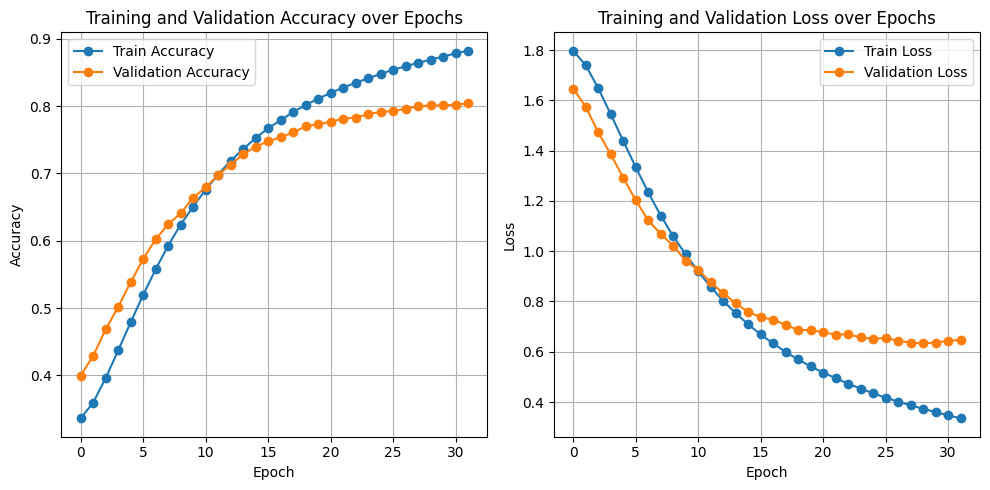

In [29]:
test_model_accuracy(model)

# Best Accuracy so far - 80%

In [31]:
from tensorflow.keras.models import load_model

model.save('cnn_20_epochs.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [32]:
model2 = load_model('cnn_20_epochs.h5')

In [33]:
model2.predict(X_test)

313/313 [==============================] - 25s 79ms/step


array([[8.2120670e-05, 1.9780004e-05, 1.2469008e-04, ..., 4.4547647e-05,
        5.0360186e-04, 4.5970661e-04],
       [5.6883952e-11, 3.5207490e-09, 7.2194024e-15, ..., 1.2192941e-16,
        9.9999994e-01, 1.5935540e-12],
       [2.7892571e-05, 1.6922571e-05, 4.8996323e-09, ..., 7.9997409e-10,
        9.9994272e-01, 1.2371270e-05],
       ...,
       [1.0702643e-11, 8.7135972e-11, 6.6157190e-07, ..., 1.2283603e-07,
        2.6482727e-11, 1.8577770e-12],
       [9.0672515e-02, 8.7761128e-01, 8.1256969e-04, ..., 8.2178258e-06,
        5.6790243e-05, 2.1744736e-02],
       [4.1109390e-13, 3.6605316e-13, 9.6102737e-11, ..., 9.9999994e-01,
        2.7868990e-14, 4.4563431e-13]], dtype=float32)

# Evaluation of Model

In [34]:
!pip install visualkeras

313/313 [==============================] - 28s 90ms/step - loss: 0.6837 - accuracy: 0.8053
Test Accuracy : 80.53%
313/313 [==============================] - 25s 79ms/step


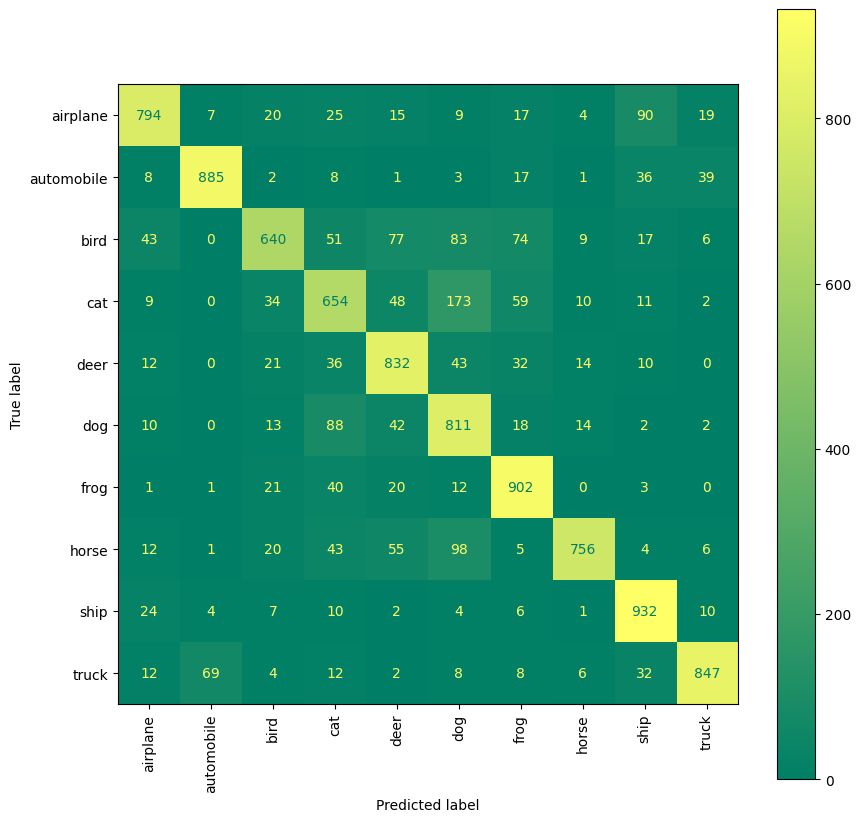

In [42]:
labels = ['airplane', 'automobile', 'bird', 'cat', 'deer',
          'dog', 'frog', 'horse', 'ship', 'truck']

evaluation = model.evaluate(X_test, y_cat_test)
print(f'Test Accuracy : {evaluation[1] * 100:.2f}%')

y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
cm = confusion_matrix(y_test, y_pred)


disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=labels)


# NOTE: Fill all variables here with default values of the plot_confusion_matrix
fig, ax = plt.subplots(figsize=(10, 10))
disp = disp.plot(xticks_rotation='vertical', ax=ax,cmap='summer')

plt.show()

In [43]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.79      0.82      1000
           1       0.92      0.89      0.90      1000
           2       0.82      0.64      0.72      1000
           3       0.68      0.65      0.66      1000
           4       0.76      0.83      0.79      1000
           5       0.65      0.81      0.72      1000
           6       0.79      0.90      0.84      1000
           7       0.93      0.76      0.83      1000
           8       0.82      0.93      0.87      1000
           9       0.91      0.85      0.88      1000

    accuracy                           0.81     10000
   macro avg       0.81      0.81      0.81     10000
weighted avg       0.81      0.81      0.81     10000



## Testing against 1 image

 Image 100 is [4]
1/1 [==============================] - 0s 23ms/step
The model predict that image 100 is deer


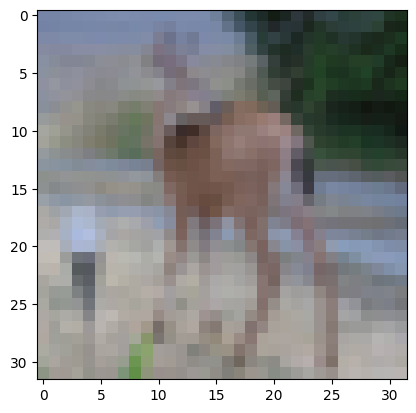

In [44]:
# Define the labels of the dataset
labels = ['airplane', 'automobile', 'bird', 'cat', 'deer',
          'dog', 'frog', 'horse', 'ship', 'truck']

my_image = X_test[100]
plt.imshow(my_image)

# that's a Deer
print(f" Image 100 is {y_test[100]}")

# correctly predicted as a Deer
pred_100 = np.argmax(model.predict(my_image.reshape(1, 32, 32, 3)))
print(f"The model predict that image 100 is {labels[pred_100]}")

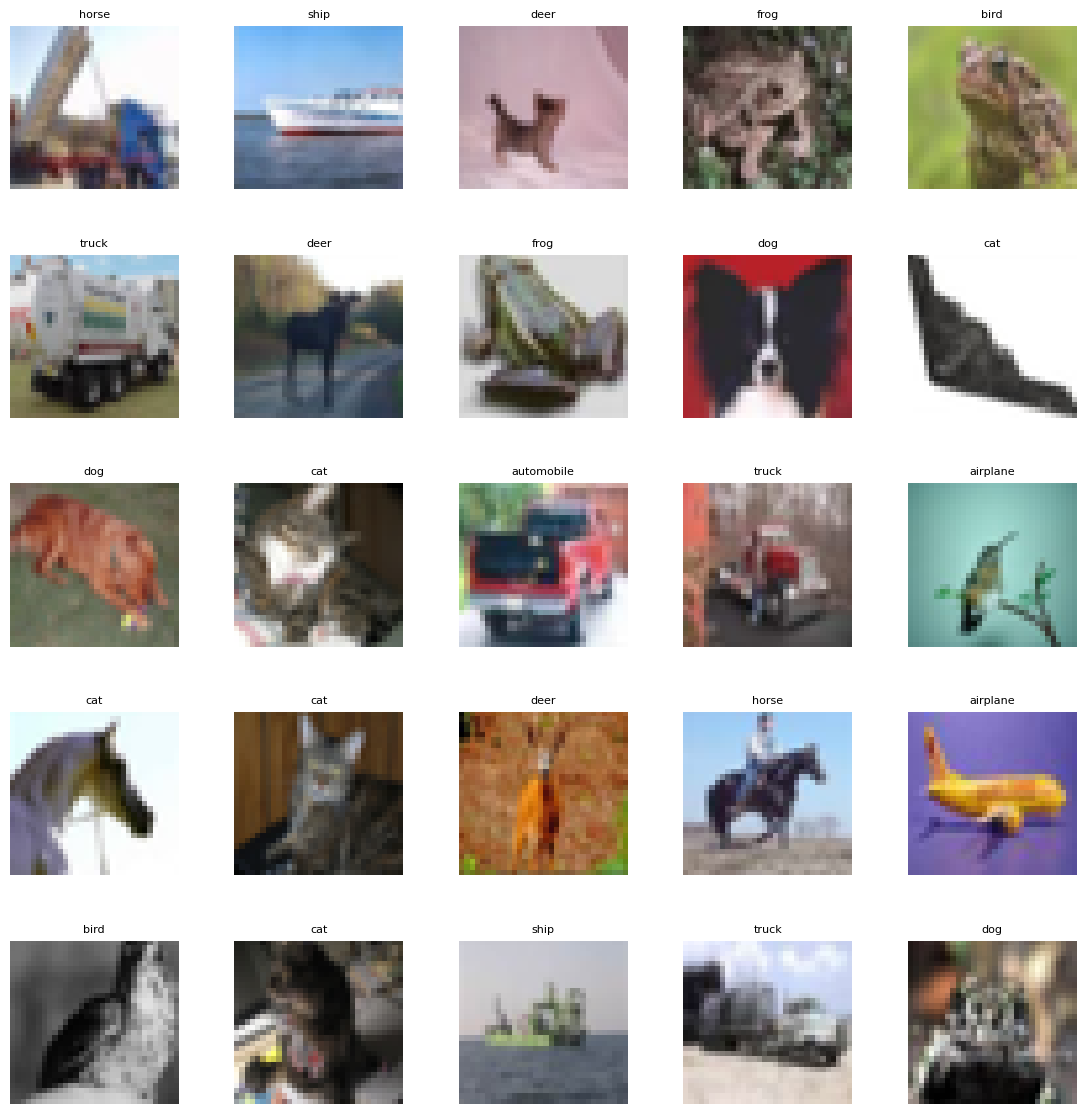

In [45]:
# Let's view more images in a grid format
# Define the dimensions of the plot grid
W_grid = 5
L_grid = 5

# fig, axes = plt.subplots(L_grid, W_grid)
# subplot return the figure object and axes object
# we can use the axes object to plot specific figures at various locations

fig, axes = plt.subplots(L_grid, W_grid, figsize = (14,14))

axes = axes.ravel() # flaten the 15 x 15 matrix into 225 array

n_test = len(X_test) # get the length of the train dataset

# Select a random number from 0 to n_train
for i in np.arange(0, W_grid * L_grid): # create evenly spaces variables

    # Select a random number
    index = np.random.randint(0, n_test)
    # read and display an image with the selected index
    axes[i].imshow(X_test[index,1:])
    label_index = int(y_pred[index])
    axes[i].set_title(labels[label_index], fontsize = 8)
    axes[i].axis('off')

plt.subplots_adjust(hspace=0.4)

In [46]:
predictions = model.predict(X_test)


313/313 [==============================] - 25s 79ms/step


# Visualizing the output Probabilities

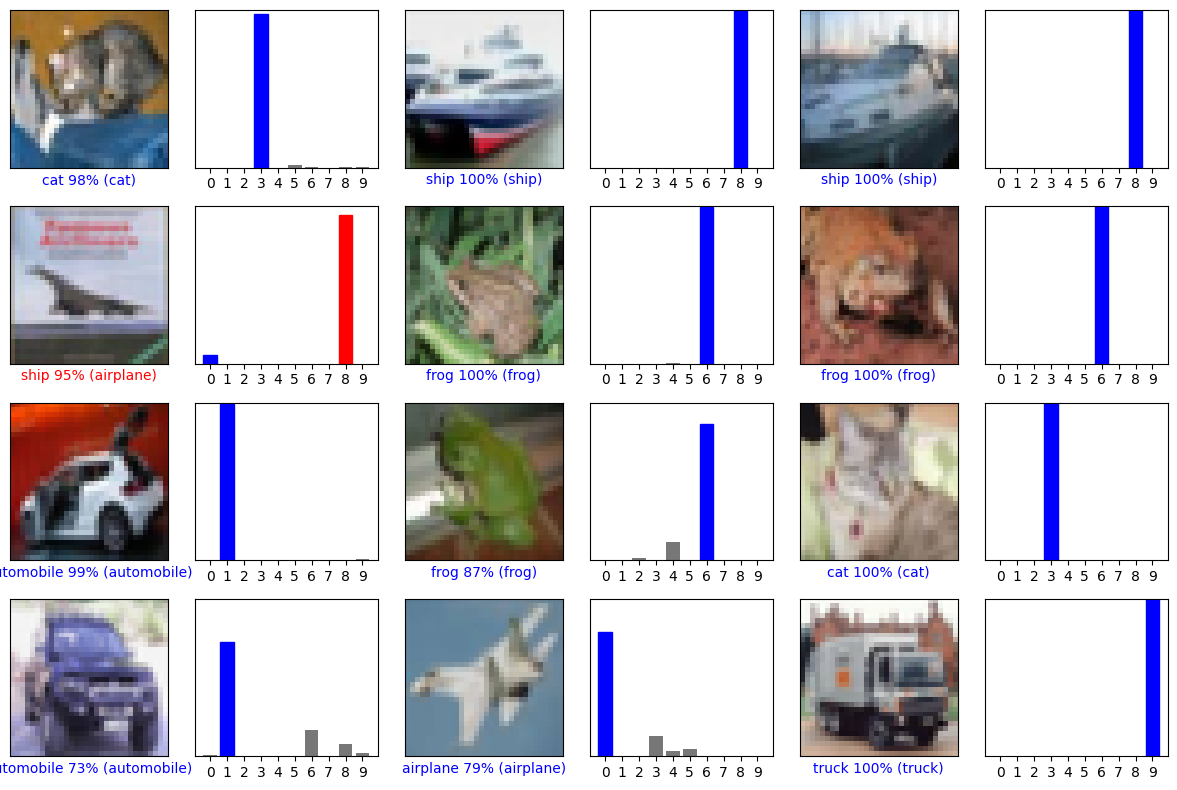

In [47]:
def plot_image(i, predictions_array, true_label, img):
    predictions_array, true_label, img = predictions_array, true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    plt.imshow(img, cmap=plt.cm.binary)

    predicted_label = np.argmax(predictions_array)
    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'

    plt.xlabel(f"{labels[int(predicted_label)]} {100*np.max(predictions_array):2.0f}% ({labels[int(true_label)]})",
               color=color)

def plot_value_array(i, predictions_array, true_label):
    predictions_array, true_label = predictions_array, int(true_label[i])
    plt.grid(False)
    plt.xticks(range(10))
    plt.yticks([])
    thisplot = plt.bar(range(10), predictions_array, color="#777777")
    plt.ylim([0, 1])
    predicted_label = np.argmax(predictions_array)

    thisplot[predicted_label].set_color('red')
    thisplot[true_label].set_color('blue')

# Plot the first X test images, their predicted labels, and the true labels.
# Color correct predictions in blue and incorrect predictions in red.
num_rows = 4
num_cols = 3
num_images = num_rows * num_cols
plt.figure(figsize=(2 * 2 * num_cols, 2 * num_rows))
for i in range(num_images):
    plt.subplot(num_rows, 2 * num_cols, 2 * i + 1)
    plot_image(i, predictions[i], y_test, X_test)
    plt.subplot(num_rows, 2*num_cols, 2*i+2)
    plot_value_array(i, predictions[i], y_test)
plt.tight_layout()
plt.show()

